In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

# My Python Modules
import FFIndustry as ffi
import FYP_fns as fyp
import importlib
importlib.reload(ffi)
importlib.reload(fyp)

import warnings
warnings.filterwarnings("ignore")

from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
import statsmodels.formula.api as smf
from scipy.stats import kurtosis
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Descriptive Statistics

In [2]:
reg_df = pd.read_parquet('/Users/kevinpark/Desktop/FYP/CleanCode_reg_df_des.parquet')
print(reg_df['gvkey'].nunique(), reg_df.shape)

robust_raw = pd.read_parquet('/Users/kevinpark/Desktop/FYP/CleanCode_robust_raw_des.parquet')
print(robust_raw['gvkey'].nunique(), robust_raw.shape)

reg_df_bal = pd.read_parquet('/Users/kevinpark/Desktop/FYP/CleanCode_reg_df_bal_des.parquet')
print(reg_df_bal['gvkey'].nunique(), reg_df_bal.shape)

# variables for descriptive analysis
des_BVs = ['age', 'at', 'sale', 'T_Debt','gdwl', 'ppent',
           'intan_cap', 'intan_cap_lessgdwl',
           'knowledge_cap', 'organization_cap',
           'intan', 'intan_lessgdwl']
des_ratios = ['LEV_TD', 'Mkt_LEV', 
              'Market_to_Book', 'Op_profit', 'Cash_liq','MTR_BI', 'MTR_AI',
              'PPENT_AT', 'intan_cap_AT', 'intan_cap_lessgdwl_AT', 
              'intan_AT', 'intan_lessgdwl_AT', 
              'know_cap_AT', 'organ_cap_AT',
              'log_asset', 'log_sale'] # 'Altman_Z',
winsor_cols = ['at', 'gdwl', 'ppent', 'sale', 'age',
               'knowledge_cap', 'organization_cap', 
               'intan_cap', 'intan_cap_lessgdwl', 
               'intan', 'intan_lessgdwl',
               'T_Debt', 'MV_CE', 'LEV_TD', 'Mkt_LEV', 
               'Market_to_Book', 'Op_profit', 'Cash_liq',
               'log_asset', 'log_sale', 
               'intan_cap_AT', 'intan_cap_lessgdwl_AT', 'intan_AT', 'intan_lessgdwl_AT', 
               'know_cap_AT', 'organ_cap_AT', 'PPENT_AT'] # 'log_MV_CE',

DV = ['LEV_TD', 'Mkt_LEV']
main_IV = ['intan_cap_AT', 'PPENT_AT']
main_IV_parts = ['know_cap_AT', 'organ_cap_AT', 'intan_AT', 'PPENT_AT']
main_IV_parts_LGDWL = ['know_cap_AT', 'organ_cap_AT', 'intan_lessgdwl_AT', 'PPENT_AT']
Controls = ['age', 'log_asset', 'Market_to_Book', 'Op_profit', 'Cash_liq', 'MTR_AI']
Hetero_vars = ['intan_cap_AT', 'High_Tan', 'HiTan_INT', 'After2015', 'T2_INT', 'HiTan_T2_INT']

3416 (32908, 48)
6383 (126514, 48)
1641 (21333, 48)


In [3]:
# def filter_pubreg(reg_df):
#     len_0 = reg_df['gvkey'].nunique()

#     # regulated utilities (4900–4999)
#     reg_df = reg_df[~(4900 <= reg_df['sic_copy']) & (reg_df['sic_copy'] <= 4999)]
#     # public service, international affairs, or non-operating establishments (9000+).
#     reg_df = reg_df[~(9000 <= reg_df['sic_copy'])]

#     len_1 = reg_df['gvkey'].nunique()
#     print(len_0, len_1)
#     print('lost', len_0 - len_1)
#     return reg_df

# reg_df = filter_pubreg(reg_df)
# robust_raw = filter_pubreg(robust_raw)
# reg_df_bal = filter_pubreg(reg_df_bal)

In [4]:
# financial firms (6000–6999)
reg_df[(6000 <= reg_df['sic_copy']) & (reg_df['sic_copy'] <= 6999)]

Empty DataFrame
Columns: [gvkey, fyear, tic, at, ceq, gdwl, intan, ppent, sale, sic, age, MTR_BI, MTR_AI, sic_copy, sic_code, knowledge_cap, organization_cap, intan_cap, intan_cap_lessgdwl, intan_lessgdwl, T_Debt, MV_CE, FMV, LEV_TD, Mkt_LEV, Market_to_Book, Op_profit, Cash_liq, log_asset, log_MV_CE, log_sale, intan_cap_AT, intan_AT, intan_cap_lessgdwl_AT, intan_lessgdwl_AT, know_cap_AT, organ_cap_AT, PPENT_AT, Shops, Bus_Equipment, Utilities, Healthcare, Manufacturing, Chemicals, Cons_Nondurables, Energy, Cons_Durables, Telecom]
Index: []

[0 rows x 48 columns]

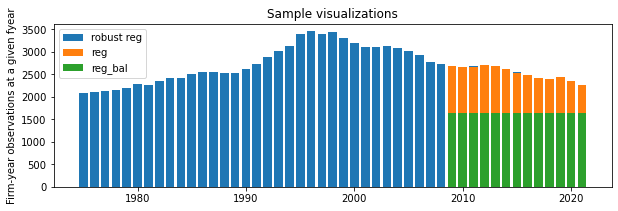

In [5]:
plt.figure(figsize=(10,3))
### robust raw
plt.bar(robust_raw['fyear'].value_counts().index,
        robust_raw['fyear'].value_counts(), label='robust reg');
### reg
plt.bar(reg_df['fyear'].value_counts().index,
        reg_df['fyear'].value_counts(), label='reg');
### reg bal
plt.bar(reg_df_bal['fyear'].value_counts().index,
        reg_df_bal['fyear'].value_counts(), label='reg_bal');
plt.title('Sample visualizations')
plt.ylabel('Firm-year observations at a given fyear')
plt.legend();

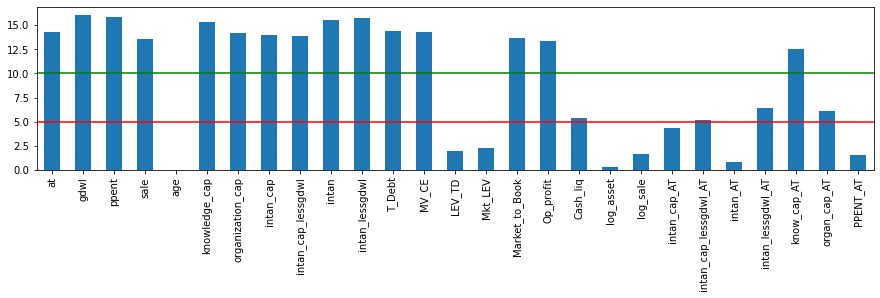

In [6]:
plt.figure(figsize=(15,3))
fyp.vis_outliers(reg_df[winsor_cols])
plt.axhline(5,color='red')
plt.axhline(10,color='green');
## % outliers above 10%: at, gdwl, ppent, sale, knowledge_cap, organization_cap, intan_cap, intan_cap_lessgdwl
## intan, intan_lessgdwl, T_Debt, MV_CE, Market_to_Book, Op_profit, know_cap_AT

## % outliers above 5%: Cash_liq, intan_cap_lessgdwl_AT, intan_lessgdwl_AT, organ_cap_AT

In [7]:
## % outliers above 10%: at, gdwl, ppent, sale, knowledge_cap, organization_cap, intan_cap, intan_cap_lessgdwl
## intan, intan_lessgdwl, T_Debt, MV_CE, Market_to_Book, Op_profit, know_cap_AT

## % outliers above 5%: Cash_liq, intan_cap_lessgdwl_AT, intan_lessgdwl_AT, organ_cap_AT

# at: + skew 
# gdwl: + skew
# ppent: + skew
# sale: + skew
# knowledge_cap: + skew
# organization_cap: + skew
# intan_cap: + skew
# intan_cap_lessgdwl: + skew
# intan: + skew
# intan_lessgdwl: + skew
# T_Debt: + skew
# MV_CE: + skew
# LEV_TD: + skew
# Mkt_LEV: + skew
# Market_to_Book: ?
# Op_profit: ?
# Cash_liq: + skew
# log_asset: normal
# log_sale: normal
# intan_cap_AT: + skew
# intan_cap_lessgdwl_AT: + skew
# intan_AT: + skew
# intan_lessgdwl_AT: + skew
# know_cap_AT: + skew
# organ_cap_AT: + skew
# PPENT_AT: + skew

# for var in winsor_cols:
#     plt.figure(figsize=(15,4))
#     print(f'{var} kurt: ', kurtosis(reg_df[var]))
#     plt.title(f'{var}')
#     plt.hist(reg_df[var], bins=60)

In [8]:
## % outliers above 10%: at, gdwl, ppent, sale, knowledge_cap, organization_cap, intan_cap, intan_cap_lessgdwl
## intan, intan_lessgdwl, T_Debt, MV_CE, Market_to_Book, Op_profit, know_cap_AT

## % outliers above 5%: Cash_liq, intan_cap_lessgdwl_AT, intan_lessgdwl_AT, organ_cap_AT

# at: + skew 
# gdwl: + skew
# ppent: + skew
# sale: + skew
# knowledge_cap: + skew
# organization_cap: + skew
# intan_cap: + skew
# intan_cap_lessgdwl: + skew
# intan: + skew
# intan_lessgdwl: + skew
# T_Debt: + skew
# MV_CE: + skew
# LEV_TD: + skew
# Mkt_LEV: + skew
# Market_to_Book: ?
# Op_profit: ?
# Cash_liq: + skew
# log_asset: normal
# log_sale: normal
# intan_cap_AT: + skew
# intan_cap_lessgdwl_AT: + skew
# intan_AT: + skew
# intan_lessgdwl_AT: + skew
# know_cap_AT: + skew
# organ_cap_AT: + skew
# PPENT_AT: + skew

# winsor_more_posskew = ['at', 'gdwl', 'ppent', 'sale',
#                        'knowledge_cap', 'organization_cap', 'intan_cap', 'intan_cap_lessgdwl',
#                        'intan', 'intan_lessgdwl', 'T_Debt', 'MV_CE',
#                        'Cash_liq', 'intan_cap_lessgdwl_AT',
#                        'intan_lessgdwl_AT', 'know_cap_AT', 'organ_cap_AT'] 

# winsor_more_sym = ['Market_to_Book', 'Op_profit']
# winsor_less_sym = ['log_asset', 'log_sale']

# winsor_less_posskew = ['LEV_TD', 'Mkt_LEV',
#                        'intan_cap_AT',
#                        'intan_AT',
#                        'PPENT_AT'] 


# reg_df = fyp.get_winsorskew_df(reg_df, winsor_less_posskew, winsor_more_posskew, side1='right', side2='right', pct1=0.05, pct2=0.15)

# reg_df = fyp.get_winsor_df(reg_df, winsor_less_sym, winsor_more_sym, pct1=0.01, pct2=0.05)


before: [2009. 2010. 2011. 2012. 2013. 2014. 2015.]
after: [2016. 2017. 2018. 2019. 2020. 2021.]


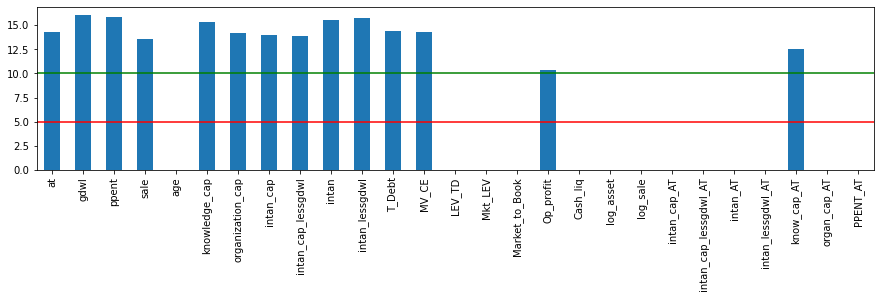

In [9]:
winsor_more = ['at', 'gdwl', 'ppent', 'sale',
               'knowledge_cap', 'organization_cap', 'intan_cap', 'intan_cap_lessgdwl',
               'intan', 'intan_lessgdwl', 'T_Debt', 'MV_CE',
               'Market_to_Book', 'Op_profit',
               'Cash_liq', 'intan_cap_lessgdwl_AT',
               'intan_lessgdwl_AT', 'know_cap_AT', 'organ_cap_AT'] 

winsor_less = ['LEV_TD', 'Mkt_LEV', 
               'log_asset', 'log_sale',
               'intan_cap_AT',
               'intan_AT',
               'PPENT_AT'] #'log_MV_CE',

importlib.reload(fyp)
reg_df_w = fyp.get_winsor_df(reg_df, winsor_less, winsor_more, pct1=0.05, pct2=0.1) # pct1=0.05, pct2=0.1
# reg_df_bal_w = fyp.get_winsor_df(reg_df_bal, winsor1, winsor2, pct1=0.05, pct2=0.1)
# robust_raw_w = fyp.get_winsor_df(robust_raw, winsor1, winsor2, pct1=0.05, pct2=0.1)


### Setting Dataset for EDA 
des_df = reg_df_w.copy()
des_df = fyp.Tangibility_dummy(des_df, visualize=False)
des_df = fyp.Time_period_dummy(des_df, T=2015)
# Check
print('before:', des_df[des_df['After2015'] == 0]['fyear'].unique())
print('after:', des_df[des_df['After2015'] == 1]['fyear'].unique())
des_df = fyp.heterogeneity_vars(des_df)

industry_dummies = list(des_df['sic'].unique())
industry_dummies.remove('Other')
columns = ['gvkey','sic','fyear','High_Tan','After2015'] + industry_dummies #'tic', , 'sic_code'
for cat_var in columns:
    des_df[cat_var] = pd.Categorical(des_df[cat_var])

## Visualize % of outliers in EDA data
plt.figure(figsize=(15,3))
fyp.vis_outliers(des_df[winsor_cols])
plt.axhline(5,color='red')
plt.axhline(10,color='green');

In [10]:
sum_table_BV = reg_df_w[des_BVs].describe().T.round(1).iloc[:,1:]
sum_table_BV.to_excel('sum_table_BV.xlsx')
sum_table_BV

mean     std   min    25%     50%     75%      max
age                   30.6    19.1   1.0   15.0    26.0    47.0     76.0
at                  3914.8  5822.4  47.5  202.7  1018.5  4594.7  18103.0
sale                2704.2  3846.9  30.9  150.7   771.4  3381.0  11911.1
T_Debt              1204.5  1913.7   0.0    6.7   201.0  1426.1   5879.6
gdwl                 453.3   773.7   0.0    0.0    40.4   463.7   2371.0
ppent               1087.4  1794.0   3.1   21.7   172.5  1102.0   5574.8
intan_cap           1440.2  2126.5  18.3   75.3   359.9  1741.5   6590.6
intan_cap_lessgdwl   718.5  1059.8   6.0   36.5   191.5   858.9   3305.0
knowledge_cap        107.5   186.0   0.0    0.0     3.3   117.4    570.7
organization_cap     413.8   605.9   0.0   21.1   112.3   494.9   1882.0
intan                711.3  1185.2   0.0    3.4    82.2   767.4   3641.5
intan_lessgdwl       195.9   336.3   0.0    0.2    19.8   197.4   1042.2

In [11]:
sum_table_ratios = reg_df_w[des_ratios].describe().T.round(3).iloc[:,1:]
sum_table_ratios.to_excel('sum_table_ratios.xlsx')
sum_table_ratios

mean    std    min    25%    50%    75%     max
LEV_TD                 0.243  0.203  0.000  0.049  0.222  0.381   0.672
Mkt_LEV                0.159  0.150  0.000  0.021  0.123  0.253   0.498
Market_to_Book         2.876  2.223  0.538  1.201  2.120  3.868   7.695
Op_profit              0.086  0.097 -0.119  0.047  0.102  0.153   0.216
Cash_liq               0.317  0.283  0.022  0.077  0.223  0.494   0.880
MTR_BI                 0.239  0.093  0.000  0.210  0.239  0.341   0.395
MTR_AI                 0.143  0.112  0.000  0.028  0.143  0.210   0.392
PPENT_AT               0.265  0.243  0.017  0.074  0.171  0.401   0.806
intan_cap_AT           0.590  0.426  0.018  0.234  0.552  0.838   1.614
intan_cap_lessgdwl_AT  0.332  0.264  0.015  0.094  0.285  0.512   0.823
intan_AT               0.192  0.202  0.000  0.014  0.119  0.327   0.637
intan_lessgdwl_AT      0.060  0.070  0.000  0.001  0.029  0.102   0.203
know_cap_AT            0.113  0.169  0.000  0.000  0.010  0.162   0.502
organ_cap_AT           0.213  0.187  0.000  0.059  0.161  0.332   0.580
log_asset              6.871  2.101  3.101  5.312  6.926  8.433  10.609
log_sale               6.529  2.121  2.409  5.015  6.648  8.126  10.089

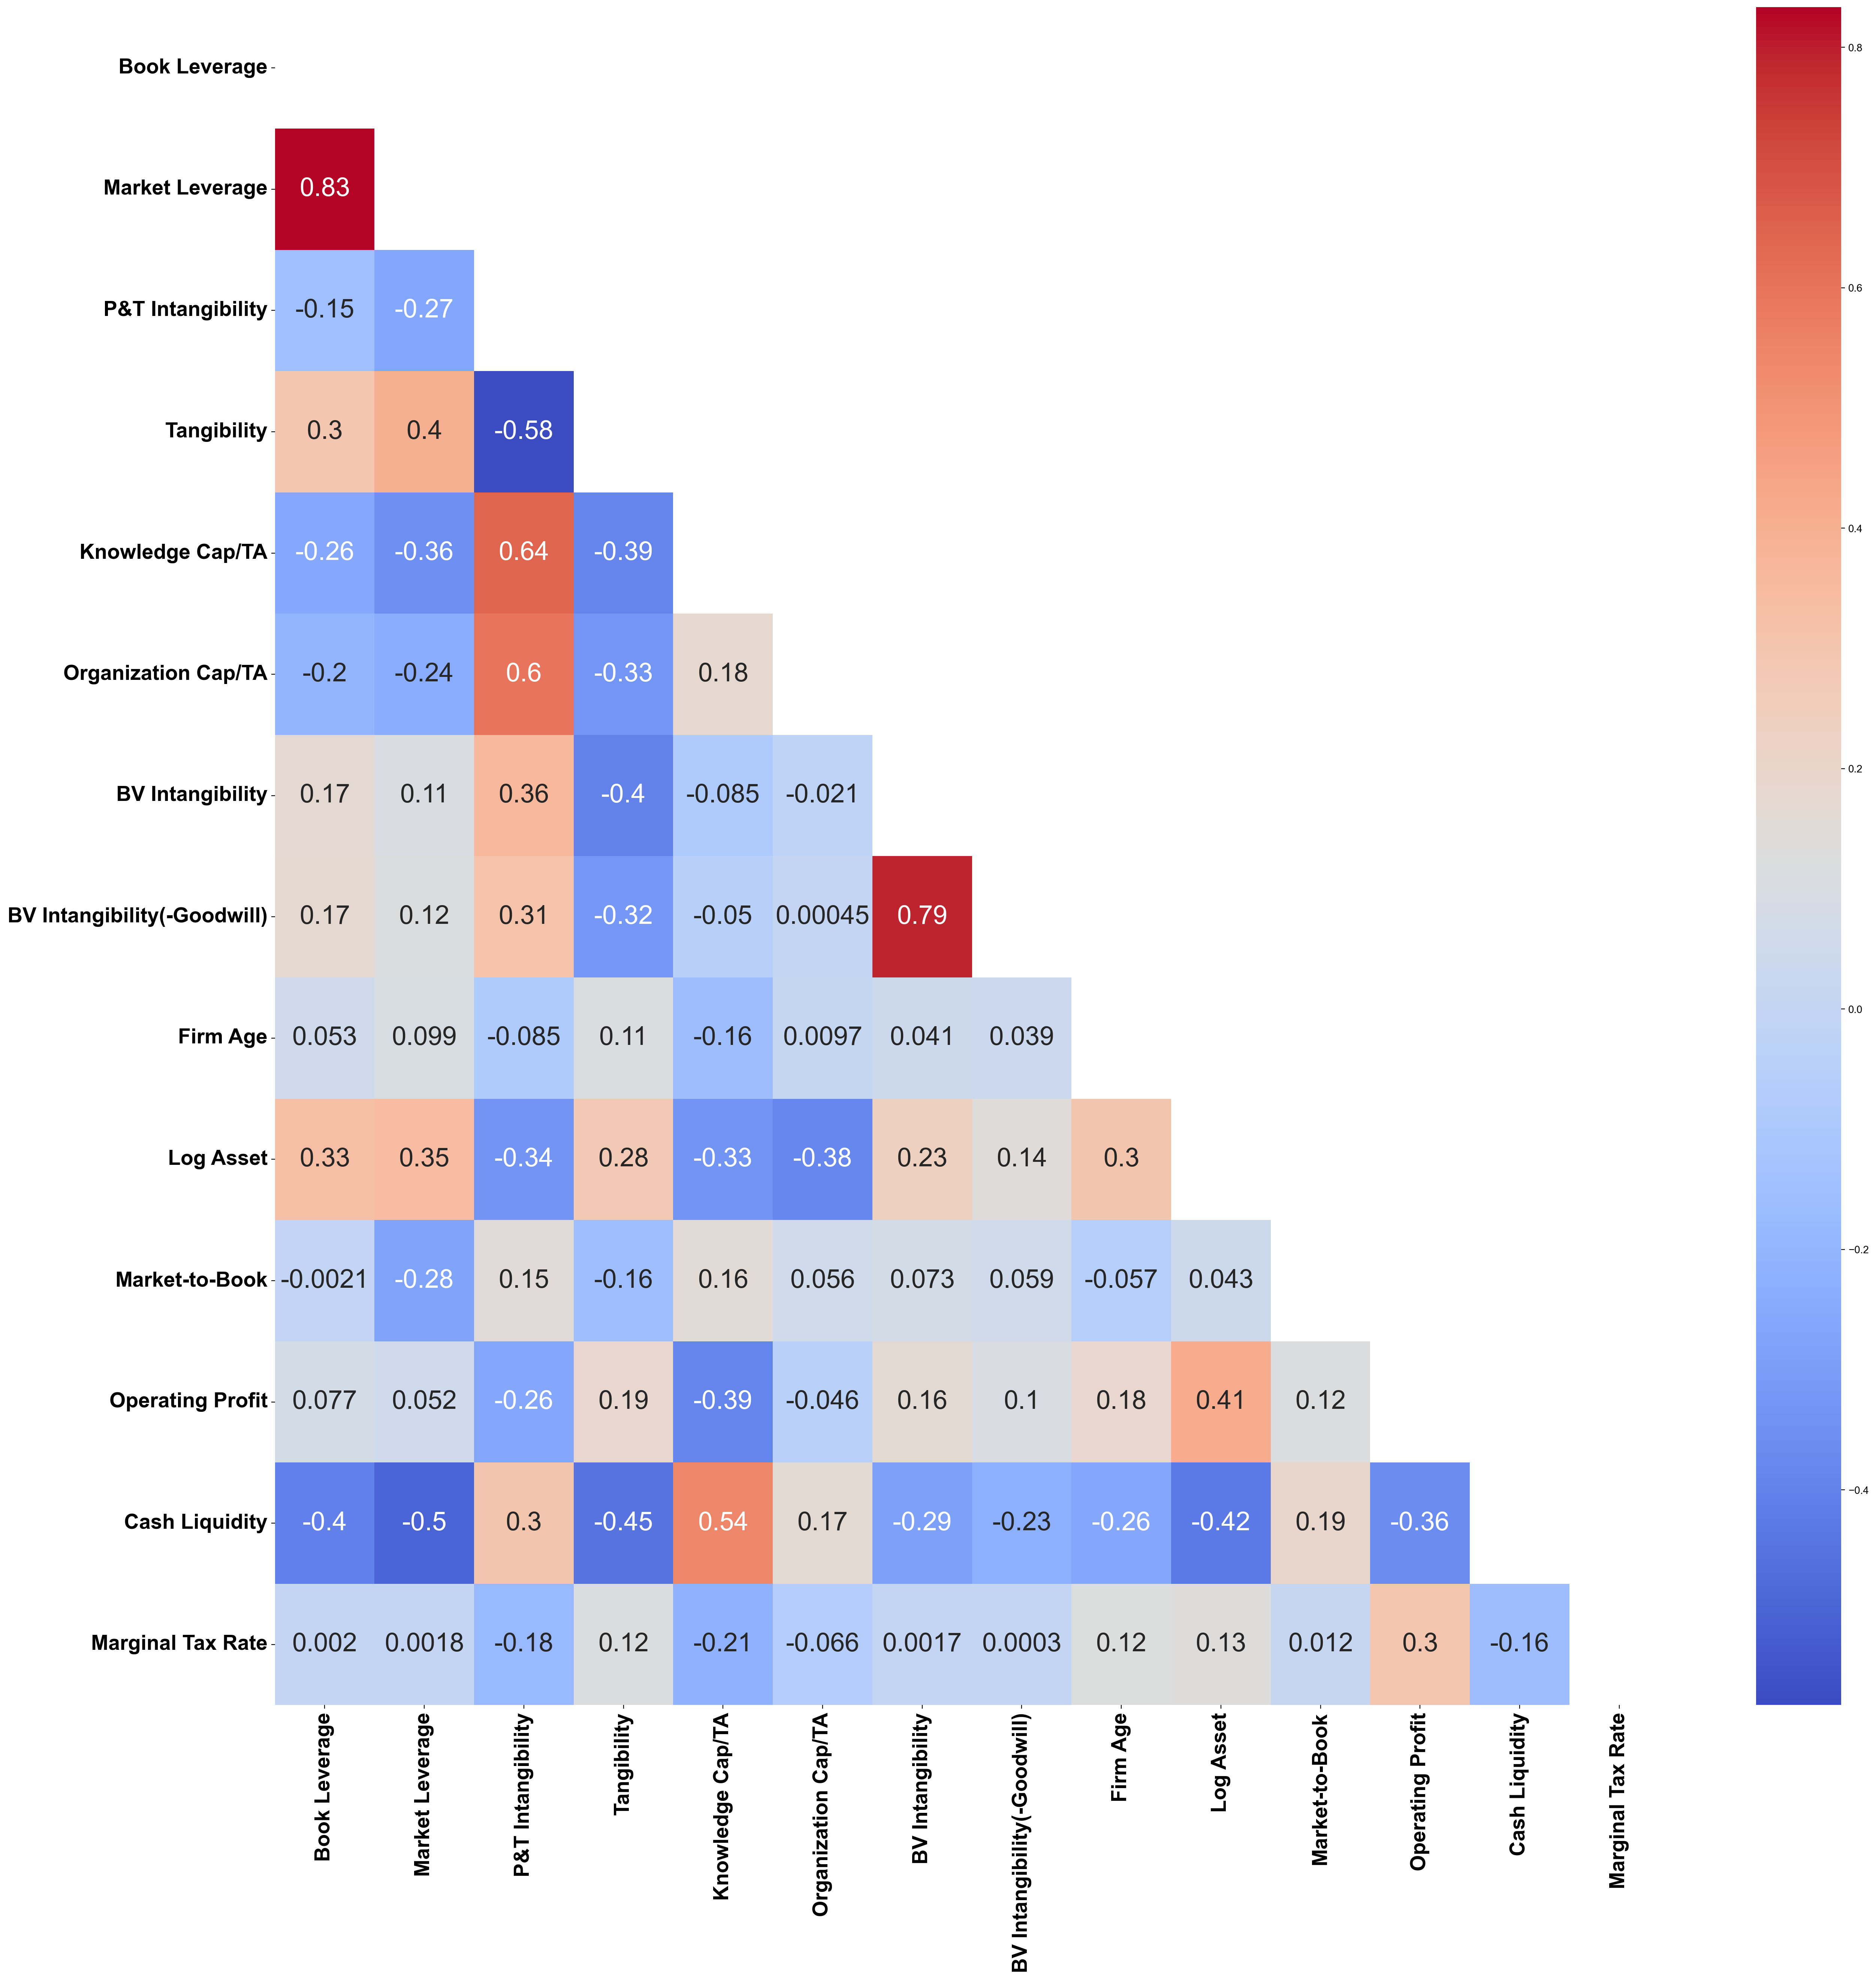

In [12]:
import seaborn as sns

all_cols = ['LEV_TD', 'Mkt_LEV',
            'intan_cap_AT', 'PPENT_AT',
            'know_cap_AT', 'organ_cap_AT',
            'intan_AT', 'intan_lessgdwl_AT',
            'age', 'log_asset', 'Market_to_Book', 'Op_profit',
            'Cash_liq', 'MTR_AI']
rename_cols = ['Book Leverage', 'Market Leverage',
            'P&T Intangibility', 'Tangibility',
            'Knowledge Cap/TA', 'Organization Cap/TA',
            'BV Intangibility', 'BV Intangibility(-Goodwill)',
            'Firm Age', 'Log Asset', 'Market-to-Book', 'Operating Profit',
            'Cash Liquidity', 'Marginal Tax Rate']

# Multicollinearity check
fig, ax = plt.subplots(figsize=(30, 30), dpi=200)
corr_matrix = reg_df_w[all_cols].set_axis(rename_cols, axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#plt.figure(figsize=(20,18), dpi=400)
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, annot_kws={"size": 25});
ax.set_xticklabels(rename_cols, rotation=90, fontsize = 20, fontweight='bold');
ax.set_yticklabels(rename_cols, rotation=0, fontsize = 20, fontweight='bold');
sns.set(font_scale=2)
plt.savefig('corr_matrix.png')

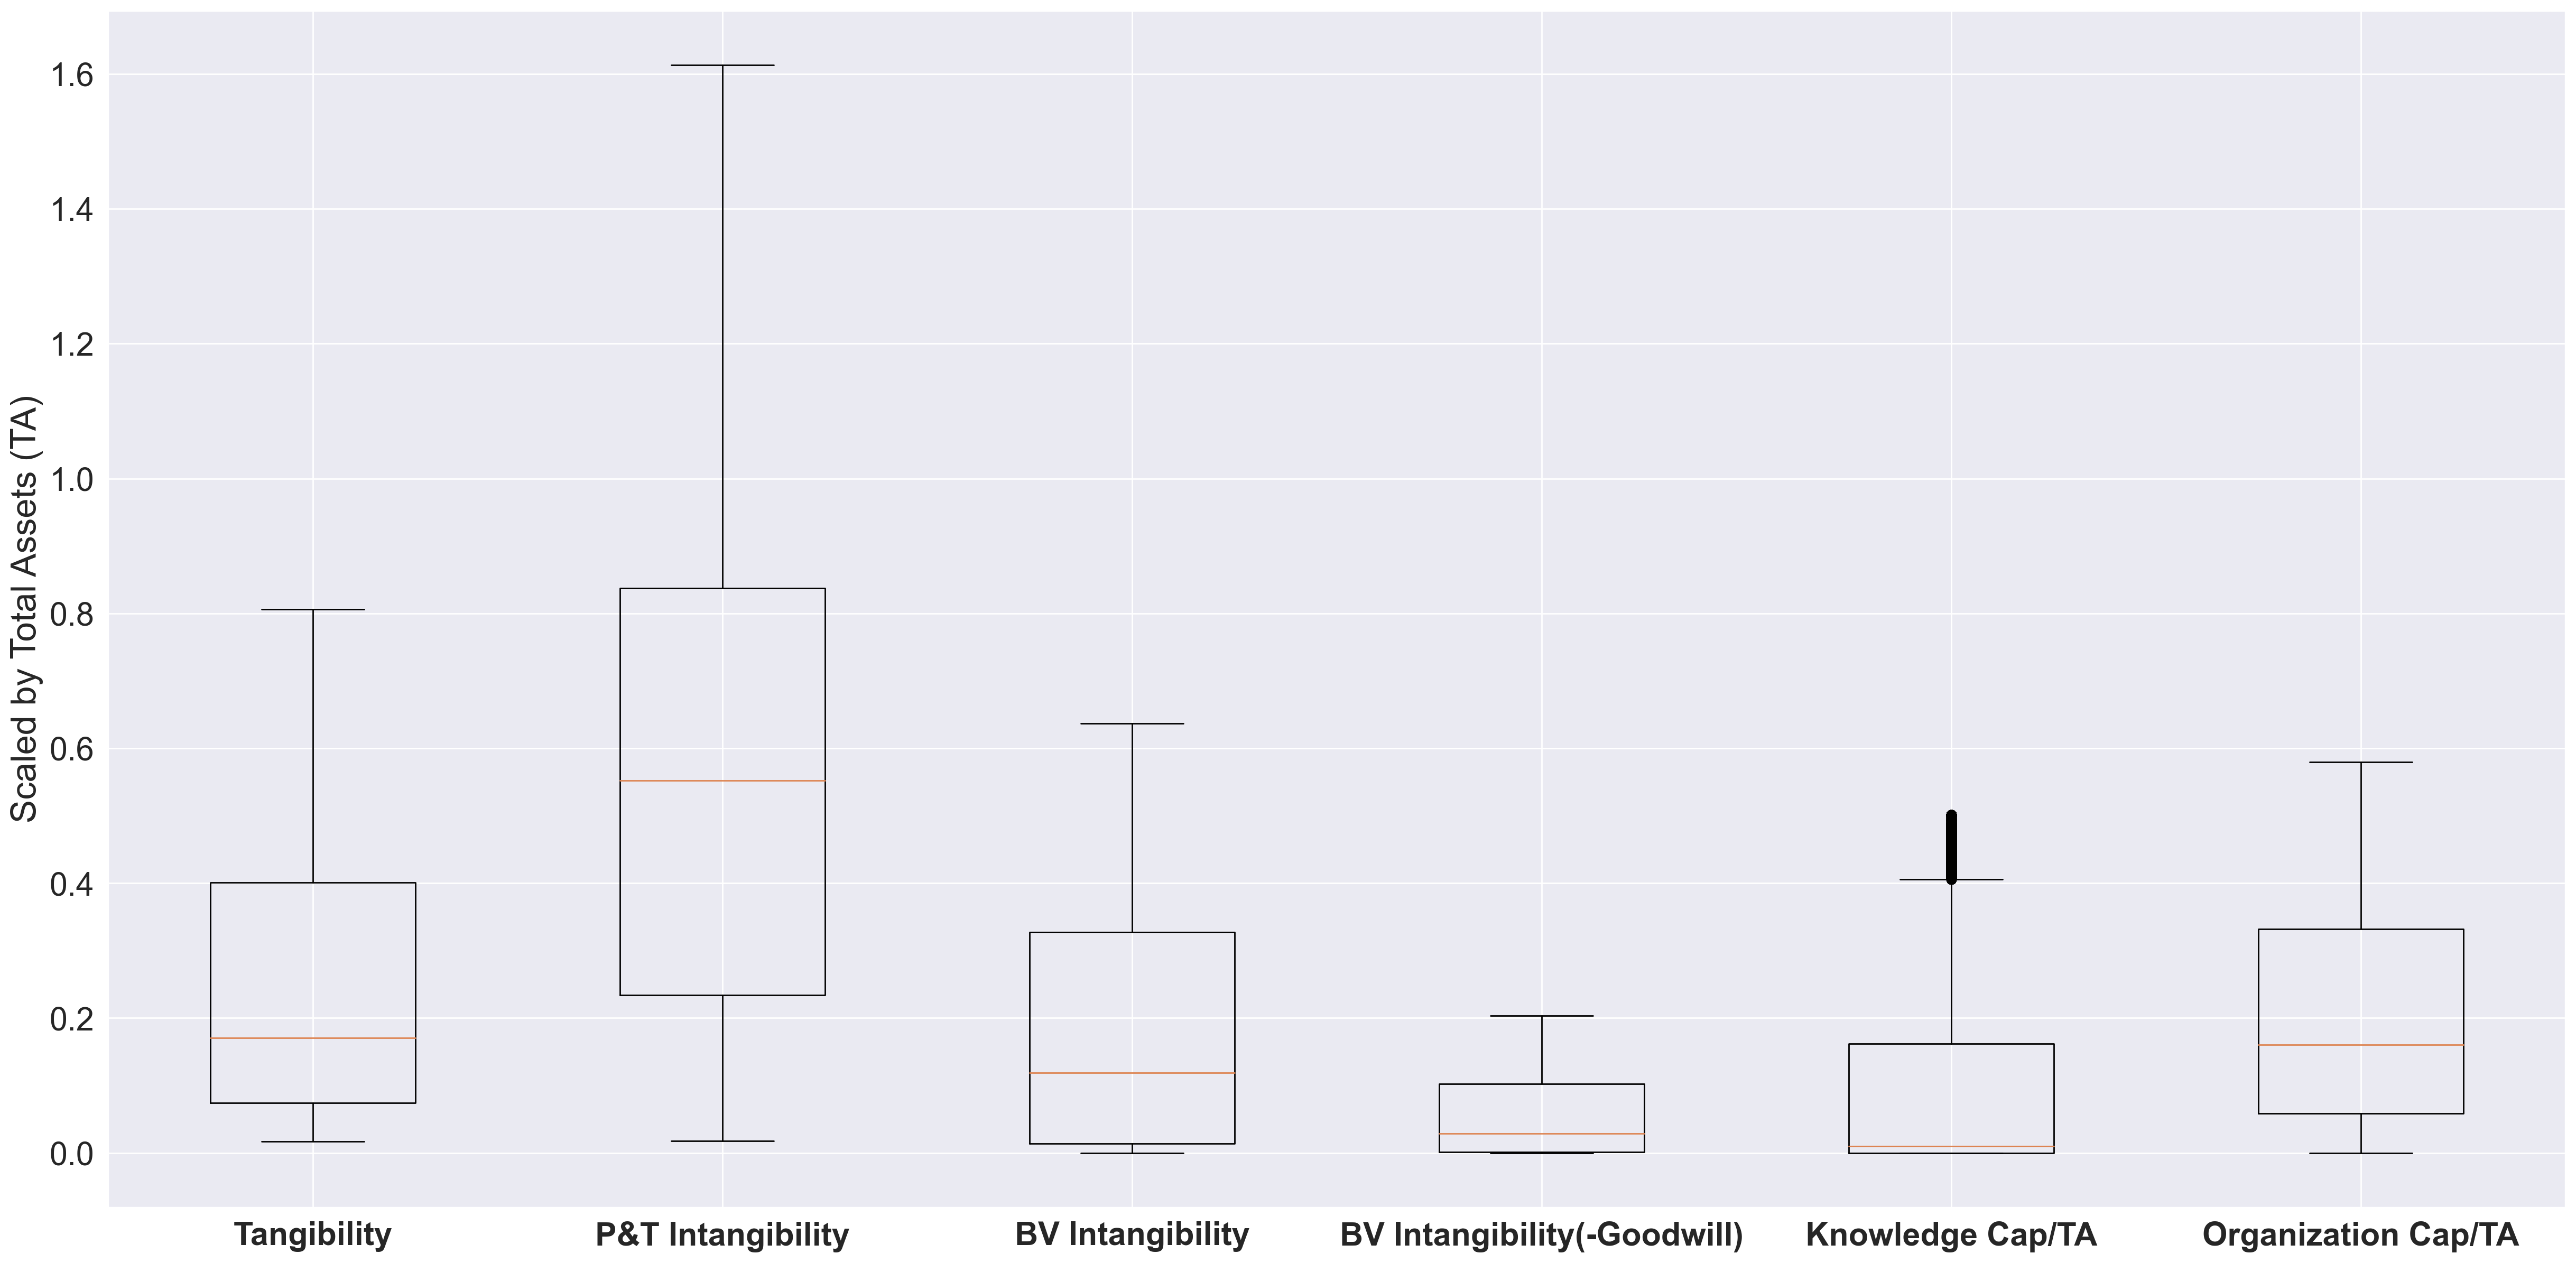

In [13]:
df = reg_df_w[['PPENT_AT', 'intan_cap_AT',
              'intan_AT', 'intan_lessgdwl_AT', 
              'know_cap_AT', 'organ_cap_AT']].set_axis(['Tangibility', 'P&T Intangibility', 
              'BV Intangibility', 'BV Intangibility(-Goodwill)', 
              'Knowledge Cap/TA', 'Organization Cap/TA'],axis=1) # des_BVs des_ratios 'intan_cap_lessgdwl_AT',  'Intangible less Goodwill/TA',
plt.figure(figsize=(30,15), dpi=200)
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=0, fontweight='bold');
plt.ylabel('Scaled by Total Assets (TA)')
plt.savefig('estimates_boxplot.png')

In [14]:
import xlwings as xw
industry_firms = reg_df_w.groupby('sic')['gvkey'].nunique()
industry_firms.index = ['Business Equipment', 'Chemicals', 'Consumer Durables', 'Consumer Nondurables',
                        'Energy', 'Healthcare', 'Manufacturing', 'Other', 'Shops', 'Telecom',
                        'Utilities']
industry_pct = round(reg_df_w.groupby('sic')['gvkey'].nunique() / reg_df_w['gvkey'].nunique() * 100, 2)
industry_pct = pd.Series(industry_pct.values, name = 'Percentage', index=None)
industry_firms = pd.DataFrame(pd.merge(industry_firms, industry_pct, on = industry_firms.index))
#print(industry_firms)

industry_N = reg_df_w['sic'].value_counts()
industry_N.index = ['Business Equipment', 'Chemicals', 'Consumer Durables', 'Consumer Nondurables',
                    'Energy', 'Healthcare', 'Manufacturing', 'Other', 'Shops', 'Telecom',
                    'Utilities']
industry_N_pct = round(reg_df_w['sic'].value_counts() / len(reg_df_w['sic']) * 100, 2)
industry_N = pd.DataFrame(pd.merge(industry_N, industry_N_pct, on=industry_N.index))
#print(industry_N)

industry_firms = pd.merge(industry_firms, industry_N, on = 'key_0').set_axis(['Industry','Firms','Firms(%)',
                                                                              'Observations','Observations(%)'], axis=1)
industry_firms.index = industry_firms['Industry']
industry_firms = industry_firms.drop(columns = ['Industry'])
print(industry_firms)
industry_firms.to_excel('industry_firms.xlsx')

wb = xw.Book('industry_firms.xlsx')
#wb.sheets[0].range('C1:C12').value = industry_pct
#wb.sheets[0].range('A:A').api.delete()

wb.sheets[0].range('A13').value = 'Total'
wb.sheets[0].range('B13').value = reg_df_w['gvkey'].nunique()
wb.sheets[0].range('C13').value = 100
wb.sheets[0].range('D13').value = len(reg_df_w['sic'])
wb.sheets[0].range('E13').value = 100
#sum(wb.sheets[0].range('B2:B12').value)

                      Firms  Firms(%)  Observations  Observations(%)
Industry                                                            
Business Equipment      859     25.15          7670            23.31
Chemicals               104      3.04          5083            15.45
Consumer Durables       105      3.07          4460            13.55
Consumer Nondurables    177      5.18          3886            11.81
Energy                  178      5.21          3574            10.86
Healthcare              511     14.96          1765             5.36
Manufacturing           374     10.95          1720             5.23
Other                   497     14.55          1391             4.23
Shops                   351     10.28          1147             3.49
Telecom                 118      3.45          1137             3.46
Utilities               142      4.16          1075             3.27


CommandError: Command failed:
		OSERROR: -609
		MESSAGE: Connection is invalid.
		COMMAND: app('/Applications/Microsoft Excel.app', newinstance=(0, 1798583)).open_workbook(workbook_file_name='/Users/kevinpark/Desktop/FYP/industry_firms.xlsx', update_links=k.do_not_update_links, read_only=None, format=None, password=None, write_reserved_password=None, ignore_read_only_recommended=None, origin=None, delimiter=None, editable=None, notify=None, converter=None, add_to_mru=None, timeout=-1)

In [ ]:
reg_df_w['gvkey'].nunique()
#reg_df_w[all_cols].shape

In [ ]:
importlib.reload(fyp)
plt.style.use('default')
fyp.Industry_regvar_vis(reg_df_w, w = 12,h = 15)

In [ ]:
wins_df = des_df.copy()
#wins_df[winsor_cols] = wins_df[winsor_cols].apply(lambda x: winsorize(x, limits=[0.05, 0.05]), axis=0)

df = wins_df[des_ratios].drop(columns=['Market_to_Book','log_asset','log_sale']) # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

In [ ]:
df = des_df[des_BVs]#.drop(columns=['Market_to_Book']) # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);
plt.show()
df = reg_df[des_ratios].drop(columns=['Market_to_Book']) # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

In [ ]:
des_df.info()

In [ ]:
### Time series plot of variable means over time
df = des_df[des_BVs + ['gvkey','fyear']].drop(columns=['at','sale']).copy()
plt.figure(figsize=(15,6))
plt.plot(df.drop(columns=['gvkey']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear']).columns);
plt.grid()
plt.legend(loc='upper left');

In [ ]:
### Time series plot of variable means over time
df = des_df[des_ratios + ['gvkey','fyear']].drop(columns=['log_sale','log_asset','Market_to_Book']).copy()
plt.figure(figsize=(15,8))
plt.plot(df.drop(columns=['gvkey']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear']).columns);
plt.grid()
plt.legend(loc='upper left');

In [ ]:
### Time series plot of variable means over time
df = des_df[main_IV_parts + ['gvkey','fyear',
                               'intan_cap_lessgdwl_AT','intan_cap_AT','intan_lessgdwl_AT',
                               'LEV_TD', 'Mkt_LEV']].drop(columns=[]).copy()
plt.figure(figsize=(15,6))
plt.plot(df.drop(columns=['gvkey']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear']).columns);
plt.grid()
plt.legend(loc='upper left');

In [ ]:
# industry average over time
var = 'intan_cap_AT'
plt.figure(figsize=(15,6))
for industry in list(des_df['sic'].unique()):
    des_df.query(f'sic == "{industry}"').groupby('fyear').mean()[var].plot(label = f'{industry}')
plt.grid()
plt.legend();

plt.figure(figsize=(15,3.5))
for industry in list(des_df['sic'].unique()):
    sns.kdeplot(des_df.query(f'sic == "{industry}"').groupby('fyear').mean()[var], label=f'{industry}', shade=True)
plt.legend();

In [271]:
# Main regression
main_reg = main_IV + Controls

main_reg_book = [DV[0]] + main_IV + Controls
main_reg_mkt = [DV[1]] + main_IV + Controls

# Subcomponent regression
subcom_reg1 = main_IV_parts + Controls
subcom_reg2 = main_IV_parts_LGDWL + Controls

main_reg_book = [DV[0]] + main_IV + Controls
subcom_reg_book1 = [DV[0]] + main_IV_parts + Controls
subcom_reg_book2 = [DV[0]] + main_IV_parts_LGDWL + Controls

main_reg_mkt = [DV[1]] + main_IV + Controls
subcom_reg_mkt1 = [DV[1]] + main_IV_parts + Controls
subcom_reg_mkt2 = [DV[1]] + main_IV_parts_LGDWL + Controls

# Heterogeneity Analysis regression
Hetero_reg = Hetero_vars + Controls

Hetero_reg_book = [DV[0]] + Hetero_vars + Controls
Hetero_reg_mkt = [DV[1]] + Hetero_vars + Controls

all_var = list(set(main_reg + subcom_reg1 + subcom_reg2))

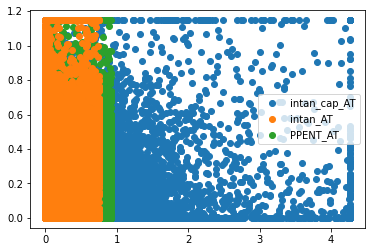

In [272]:
plt.scatter(des_df['intan_cap_AT'],des_df['LEV_TD'], label='intan_cap_AT');
plt.scatter(des_df['intan_AT'],des_df['LEV_TD'], label='intan_AT', zorder=2);
plt.scatter(des_df['PPENT_AT'],des_df['LEV_TD'], label='PPENT_AT');
plt.legend();

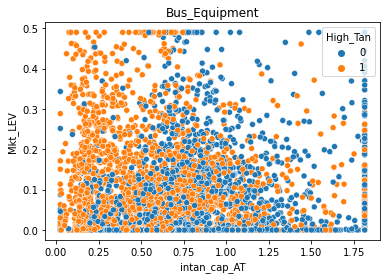

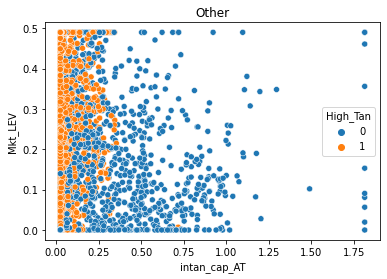

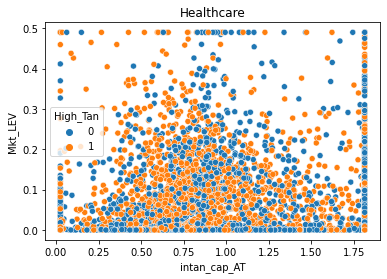

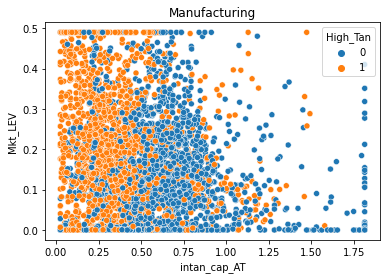

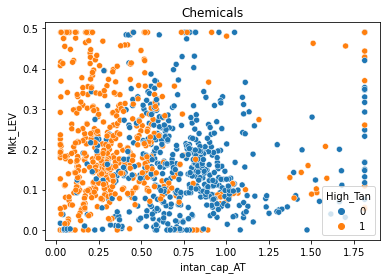

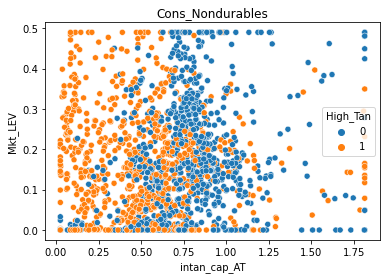

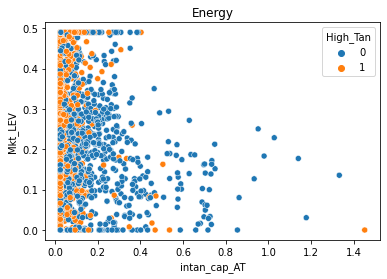

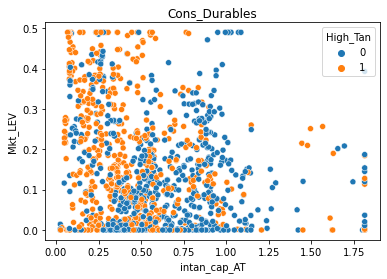

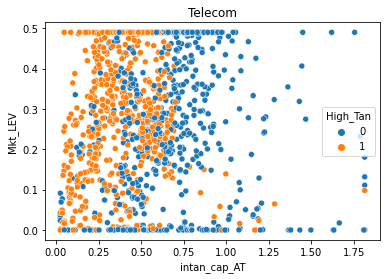

In [218]:
IV = 'intan_cap_AT'
DV = 'Mkt_LEV' #'LEV_TD'
for sector in list(des_df['sic'].unique()):
    vis_df = des_df[des_df['sic'] == sector]
    plt.title(f'{sector}')
    sns.scatterplot(vis_df[IV], vis_df[DV], hue = vis_df['High_Tan'])
    plt.show()

In [214]:
## High_Tan varies within individuals, not time-invariant
des_df.groupby('gvkey').nunique()[des_df.groupby('gvkey')['High_Tan'].nunique() > 1].head()

fyear  tic  at  ceq  gdwl  intan  ppent  sale  sic  age  ...  \
gvkey                                                           ...   
1013       2    1   2    2     2      2      2     2    1    2  ...   
1045      13    1   1   13     2      5      1     1    1   13  ...   
1161      13    1  13   13     5     13     13    13    1   13  ...   
1230      13    1  13   13     3      7      9    13    1   13  ...   
1254      13    1  13   13     5     13     13    13    1   13  ...   

       Cons_Nondurables  Energy  Cons_Durables  Telecom  Med_Tan  High_Tan  \
gvkey                                                                        
1013                  1       1              1        1        1         2   
1045                  1       1              1        1        1         2   
1161                  1       1              1        1        1         2   
1230                  1       1              1        1        1         2   
1254                  1       1              1        1        1         2   

       After2015  HiTan_INT  T2_INT  HiTan_T2_INT  
gvkey                                              
1013           1          2       1             1  
1045           2         11       7             6  
1161           2          6       6             2  
1230           2         12       7             5  
1254           2          9       7             4  

[5 rows x 53 columns]

In [215]:
des_df.groupby('gvkey')['High_Tan'].nunique() > 1

gvkey
1013       True
1045       True
1078      False
1104      False
1161       True
          ...  
315318    False
316056    False
317264    False
317427    False
345920    False
Name: High_Tan, Length: 2113, dtype: bool

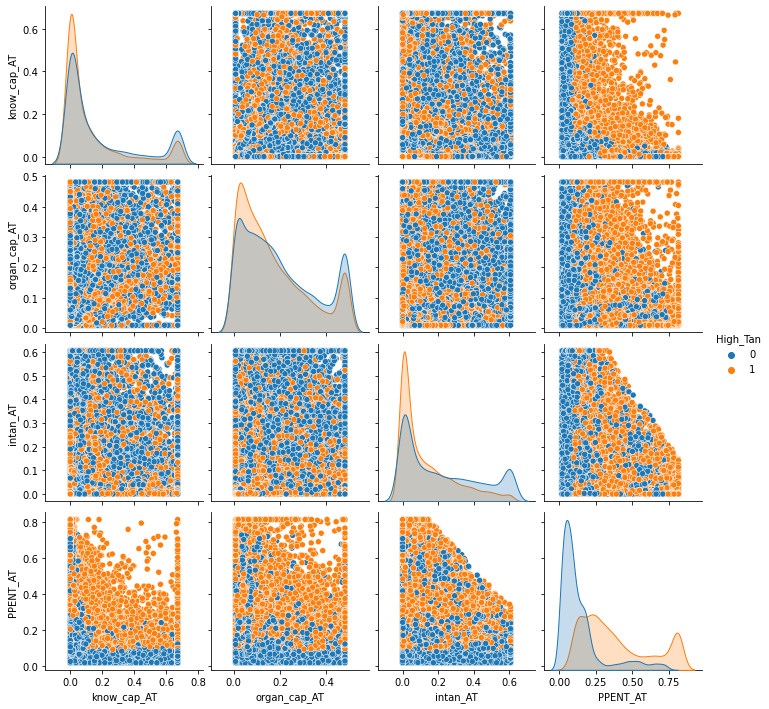

In [216]:
sns.pairplot(des_df[main_IV_parts + ['High_Tan']], hue = 'High_Tan');

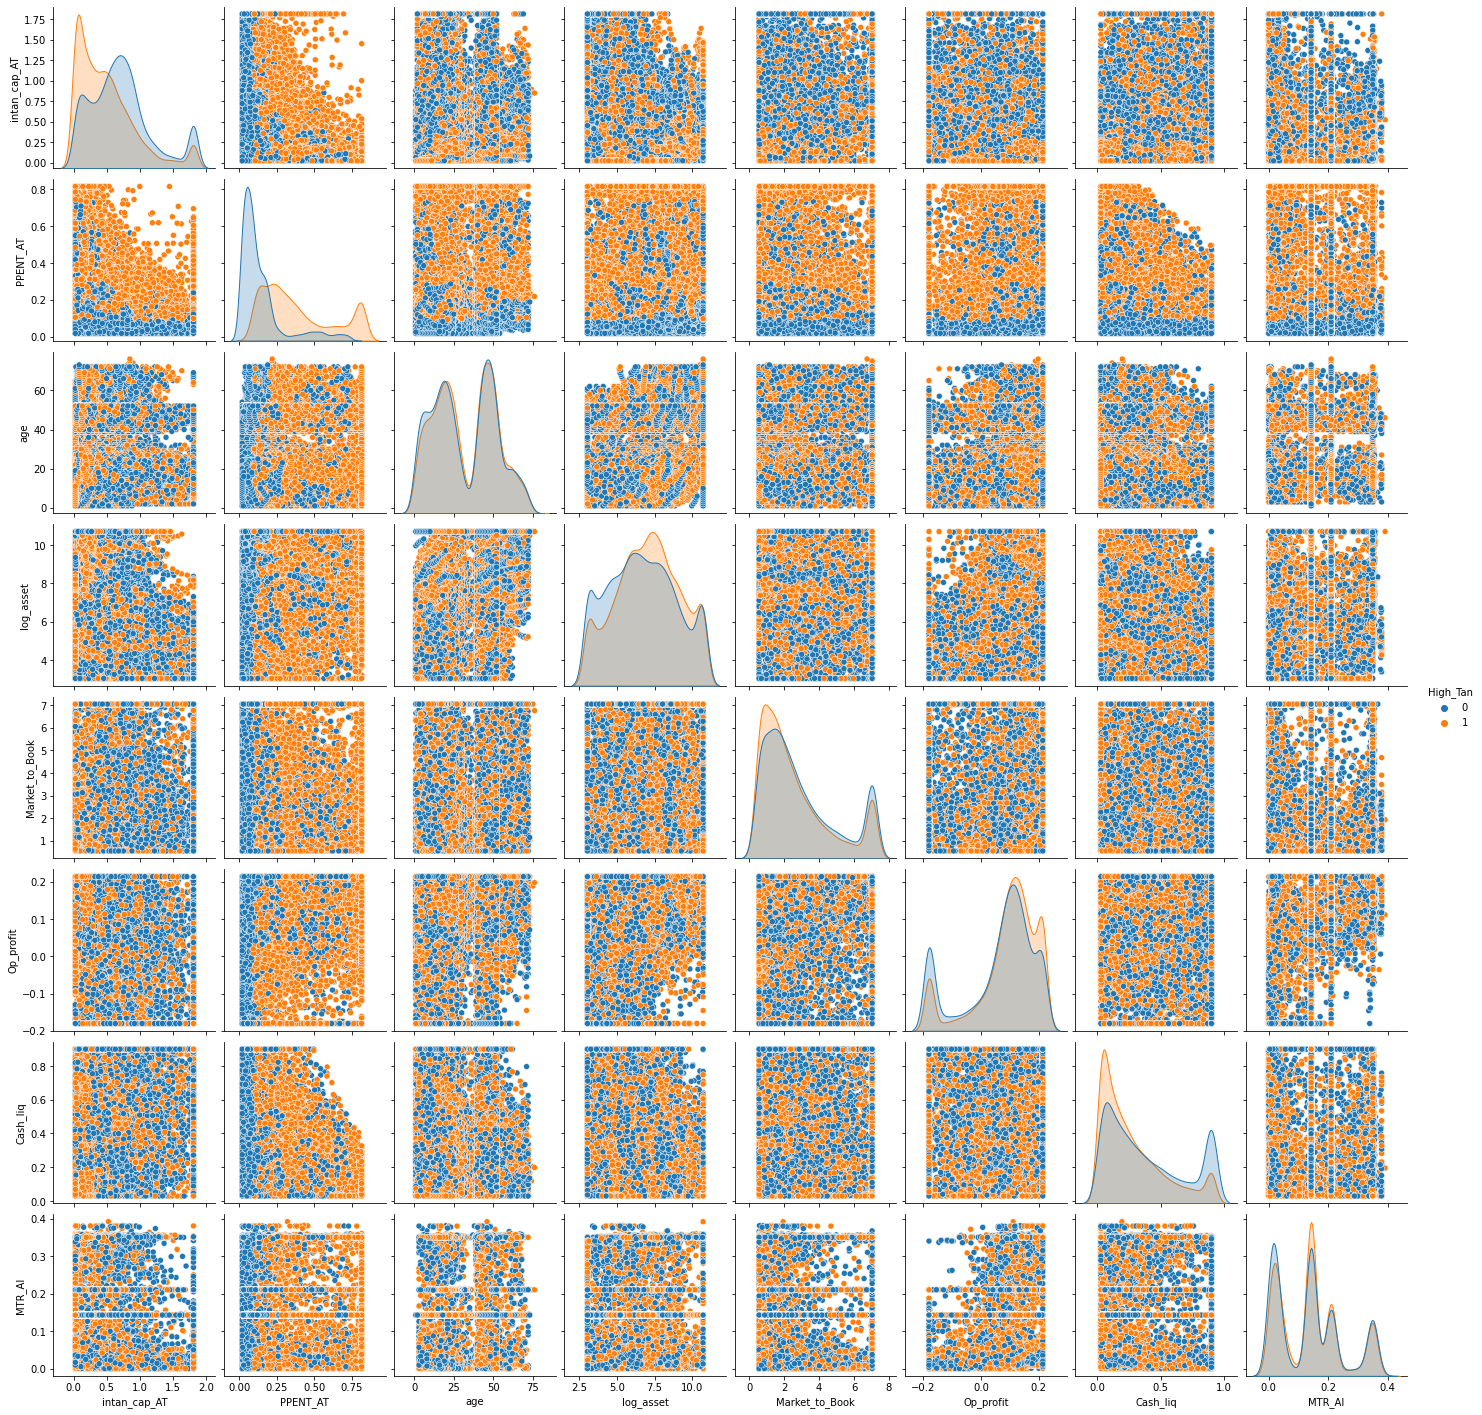

In [217]:
sns.pairplot(des_df[main_reg + ['High_Tan']], hue = 'High_Tan');

In [ ]:
# Outer is entity, inner is time
entity = list(map(chr,range(65,91)))
time = list(pd.date_range('1-1-2014',freq='A', periods=4))
index = pd.MultiIndex.from_product([entity, time])
df = pd.DataFrame(np.random.randn(26*4, 2),index=index, columns=['y','x'])

from linearmodels.panel import PanelOLS
mod = PanelOLS(df.y, df.x, entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

In [587]:
main_reg = main_IV + Controls
main_reg = ' + '.join(main_reg)
formula = DV[0] + ' ~ ' + main_reg

print('formula:', formula)

model = smf.ols(formula=formula, data=reg_df_w)
results = model.fit()
print(results.summary())

formula: LEV_TD ~ intan_cap_AT + PPENT_AT + age + log_asset + Market_to_Book + Op_profit + Cash_liq + MTR_AI
                            OLS Regression Results                            
Dep. Variable:                 LEV_TD   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     1263.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:26:22   Log-Likelihood:                 10244.
No. Observations:               32908   AIC:                        -2.047e+04
Df Residuals:                   32899   BIC:                        -2.039e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [588]:
industry_dummies

['Shops',
 'Bus_Equipment',
 'Utilities',
 'Healthcare',
 'Manufacturing',
 'Chemicals',
 'Cons_Nondurables',
 'Energy',
 'Cons_Durables',
 'Telecom']

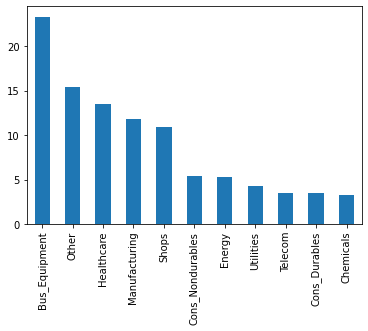

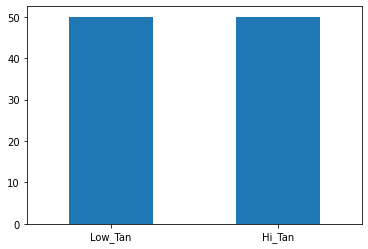

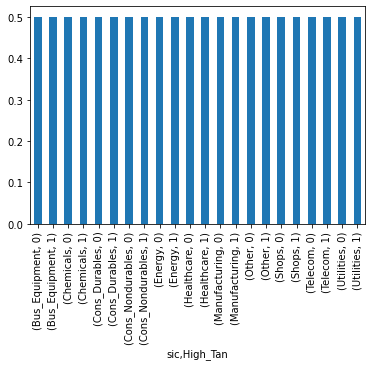

True     16888
False    16020
Name: After2015, dtype: int64

In [13]:
reg_df_w = fyp.Tangibility_dummy(reg_df_w)
reg_df_w['After2015'] = reg_df_w['fyear'] > 2014
reg_df_w['After2015'].value_counts()

In [14]:
reg_df_w['sic']

0                Shops
1                Shops
2                Shops
3                Shops
4                Shops
             ...      
32903    Bus_Equipment
32904    Manufacturing
32905    Manufacturing
32906    Manufacturing
32907    Manufacturing
Name: sic, Length: 32908, dtype: object

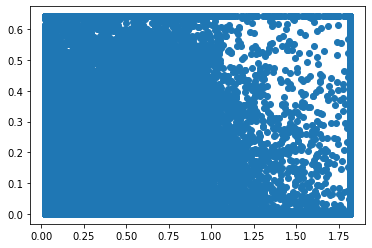

In [219]:
plt.scatter(x = reg_df_w['intan_cap_AT'], y = reg_df_w['LEV_TD']);

In [220]:
reg_df_w.columns

Index(['gvkey', 'fyear', 'tic', 'at', 'ceq', 'gdwl', 'intan', 'ppent', 'sale',
       'sic', 'age', 'MTR_BI', 'MTR_AI', 'sic_copy', 'sic_code',
       'knowledge_cap', 'organization_cap', 'intan_cap', 'intan_cap_lessgdwl',
       'intan_lessgdwl', 'T_Debt', 'MV_CE', 'FMV', 'LEV_TD', 'Mkt_LEV',
       'Market_to_Book', 'Op_profit', 'Cash_liq', 'log_asset', 'log_MV_CE',
       'log_sale', 'intan_cap_AT', 'intan_AT', 'intan_cap_lessgdwl_AT',
       'intan_lessgdwl_AT', 'know_cap_AT', 'organ_cap_AT', 'PPENT_AT', 'Shops',
       'Bus_Equipment', 'Utilities', 'Healthcare', 'Manufacturing',
       'Chemicals', 'Cons_Nondurables', 'Energy', 'Cons_Durables', 'Telecom'],
      dtype='object')

In [221]:
main_IV = ['intan_cap_AT', 'PPENT_AT']
con_IV = ['log_asset', 'age', 'Market_to_Book', 'Op_profit', 'Cash_liq', 'MTR_AI']
main_IV = ' + '.join(main_IV)
con_IV = ' + '.join(con_IV)

DV = 'LEV_TD'
formula = DV + ' ~ ' + main_IV + ' + ' + con_IV
print('formula:', formula)
model = smf.ols(formula=formula, data=reg_df_w)
results = model.fit()
print(results.summary())

formula: LEV_TD ~ intan_cap_AT + PPENT_AT + log_asset + age + Market_to_Book + Op_profit + Cash_liq + MTR_AI
                            OLS Regression Results                            
Dep. Variable:                 LEV_TD   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     748.4
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:15:37   Log-Likelihood:                 7221.5
No. Observations:               20895   AIC:                        -1.442e+04
Df Residuals:                   20886   BIC:                        -1.435e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------

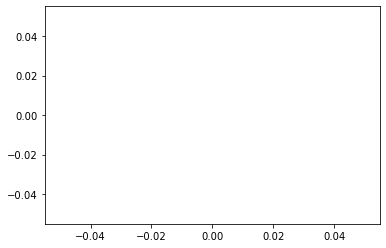

In [222]:
df = reg_df_w.query("sic == 'Shops'")[['gvkey','fyear', 'intan_cap_AT']]

plt.plot(df['fyear'], df['intan_cap_AT'])

upper: 'at'(0.15) 'sale'(0.14) 'T_Debt'(0.16) 'gdwl'(0.17) 'ppent'(0.16) 'intan_cap'(0.15) 'intan_cap_lessgdwl' (0.15)
 'knowledge_cap' (0.15) 'organization_cap'(0.15) 'intan'(0.17) 'intan_lessgdwl'(0.17) 'Cash_liq' (0.07)
 'PPENT_AT' (0.05) 'intan_cap_AT' (0.07) 'intan_cap_lessgdwl_AT' (0.08) 'intan_AT' (0.02) 'intan_lessgdwl_AT' (0.07)
 'know_cap_AT' (0.13)

'LEV_TD' (0.03) 'Mkt_LEV' (0.03)

both: 'Market_to_Book' (0.05, 0.1) 'Altman_Z' (0.07, 0.09) 'Op_profit' (0.14, 0.02) 'organ_cap_AT' (0.01, 0.07)
 'log_asset' (0.01,0.01)

lower: 'log_sale' (0.03)

In [223]:
upper20 = ['at', 'sale', 'T_Debt', 'gdwl', 'ppent', 'intan_cap',
           'intan_cap_lessgdwl', 'knowledge_cap', 'organization_cap',
           'intan', 'intan_lessgdwl', 'Cash_liq']
upper10 = ['PPENT_AT', 'intan_cap_AT', 'intan_cap_lessgdwl_AT', 'intan_AT',
           'intan_lessgdwl_AT', 'know_cap_AT','LEV_TD', 'Mkt_LEV']
both10 = ['Market_to_Book', 'Altman_Z', 'Op_profit', 'organ_cap_AT', 'log_asset', 'log_sale']
winsor_cols = ['gvkey', 'fyear','sic',
               'at', 'gdwl', 'ppent', 'sale', 'age', 'MTR_BI', 'MTR_AI',
               'knowledge_cap', 'organization_cap', 
               'intan_cap', 'intan_cap_lessgdwl', 
               'intan', 'intan_lessgdwl',
               'T_Debt', 'MV_CE', 'LEV_LTD', 'LEV_TD', 'Mkt_LEV_CE', 'Mkt_LEV', 
               'Market_to_Book', 'Altman_Z', 'Op_profit', 'Cash_liq',
               'log_asset', 'log_MV_CE', 'log_sale', 
               'intan_cap_AT', 'intan_cap_lessgdwl_AT', 'intan_AT', 'intan_lessgdwl_AT', 
               'know_cap_AT', 'organ_cap_AT', 'PPENT_AT']

# reg_df_w[upper20] = reg_df[upper20].apply(lambda x: winsorize(x, limits=[0, 0.2]), axis=0) 
# reg_df_w[upper10] = reg_df[upper10].apply(lambda x: winsorize(x, limits=[0, 0.1]), axis=0)
# reg_df_w[both10] = reg_df[both10].apply(lambda x: winsorize(x, limits=[0.1, 0.1]), axis=0)
# reg_df_w = reg_df_w[winsor_cols]

# importlib.reload(fyp)
# fyp.outlier_winsor(reg_df_w, 'know_cap_AT')

In [270]:

'+'.join(winsor_cols)

'gvkey+fyear+sic+at+gdwl+ppent+sale+age+MTR_BI+MTR_AI+knowledge_cap+organization_cap+intan_cap+intan_cap_lessgdwl+intan+intan_lessgdwl+T_Debt+MV_CE+LEV_LTD+LEV_TD+Mkt_LEV_CE+Mkt_LEV+Market_to_Book+Altman_Z+Op_profit+Cash_liq+log_asset+log_MV_CE+log_sale+intan_cap_AT+intan_cap_lessgdwl_AT+intan_AT+intan_lessgdwl_AT+know_cap_AT+organ_cap_AT+PPENT_AT'

# Median, mean ages decrease with longer period datasets
longer period dataset includes firms that died out in the past

In [18]:
age_des = pd.concat([reg_df_bal['age'].describe(), reg_df['age'].describe(), robust_raw['age'].describe()] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1).T
age_des.round(0)
age_des.to_excel('threesample_stat.xlsx')
age_des

count       mean        std  min   25%   50%   75%  \
2009-2021 Balanced     21333.0  34.739090  17.978407  1.0  19.0  31.0  49.0   
2009-2021 Unbalanced   32908.0  30.553118  19.116752  1.0  15.0  26.0  47.0   
1975-2021 Unbalanced  126514.0  23.407654  15.468829  1.0  11.0  21.0  34.0   

                       max  
2009-2021 Balanced    76.0  
2009-2021 Unbalanced  76.0  
1975-2021 Unbalanced  76.0

In [21]:
asset_des = pd.concat([reg_df_bal['log_asset'].describe(), reg_df['log_asset'].describe(), robust_raw['log_asset'].describe()] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1).T
asset_des.round(0)
asset_des

count      mean       std       min       25%  \
2009-2021 Balanced     21333.0  7.289445  2.254217 -0.765718  5.782581   
2009-2021 Unbalanced   32908.0  6.864409  2.263681 -2.198225  5.311907   
1975-2021 Unbalanced  126514.0  5.780956  2.285723 -4.074542  4.122993   

                           50%       75%        max  
2009-2021 Balanced    7.377301  8.879189  13.569377  
2009-2021 Unbalanced  6.926064  8.432667  13.569377  
1975-2021 Unbalanced  5.684688  7.378421  13.589574

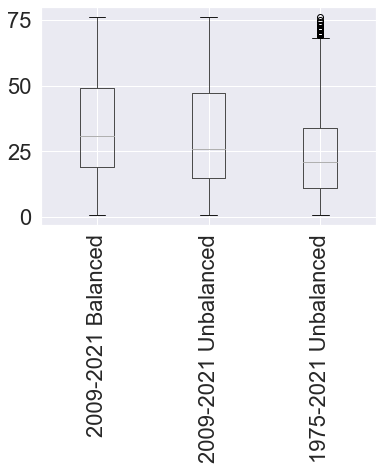

In [22]:
age_df = pd.concat([reg_df_bal['age'], reg_df['age'], robust_raw['age']] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1)
age_df.boxplot()
plt.xticks(list(range(1,len(age_df.columns)+1)), list(age_df.columns), rotation=90);

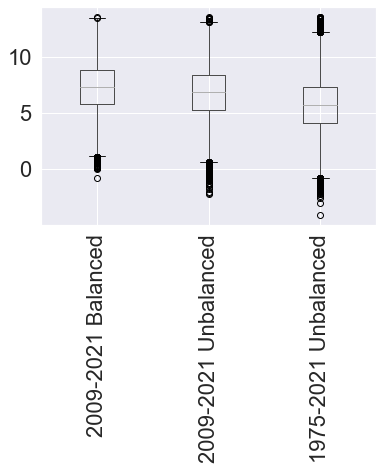

In [23]:
asset_des = pd.concat([reg_df_bal['log_asset'], reg_df['log_asset'], robust_raw['log_asset']] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1)
asset_des.boxplot()
plt.xticks(list(range(1,len(age_df.columns)+1)), list(age_df.columns), rotation=90);

In [182]:
sum_table_BV = reg_df[des_BVs].describe().T.round(1).iloc[:,1:]
sum_table_ratios = reg_df[des_ratios].describe().T.round(3).iloc[:,1:]
sum_table_BV

mean      std    min    25%    50%     75%       max
age                   30.0     19.1    1.0   14.0   25.0    47.0      76.0
at                  7745.9  28460.0    0.0  124.0  694.2  3579.9  781818.0
sale                5257.7  20612.3    0.0   76.6  542.3  2785.8  569962.0
T_Debt              2403.5  10467.2    0.0    2.6  101.0  1037.0  510192.0
gdwl                1140.9   4825.5    0.0    0.0   21.0   359.0  146370.0
ppent               2647.8  11020.6    0.0   10.9  109.8   822.1  259651.0
intan_cap           3328.0  13444.5  -14.0   59.4  285.9  1471.1  365567.3
intan_cap_lessgdwl  1849.2   8429.4  -14.2   30.5  158.3   733.3  259486.6
knowledge_cap        592.8   3849.5    0.0    0.0    8.1   124.7  166951.1
organization_cap     884.7   3853.5 -147.5   13.2   84.8   410.7  153907.0
intan               1850.6   8633.3    0.0    0.7   50.2   588.9  310197.0
intan_lessgdwl       709.6   4489.1    0.0    0.0   12.5   154.9  163827.0

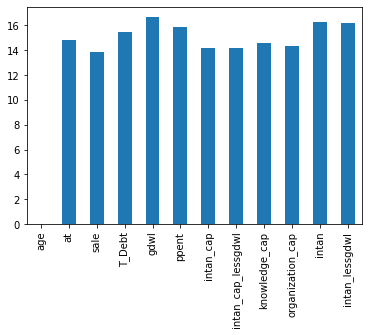

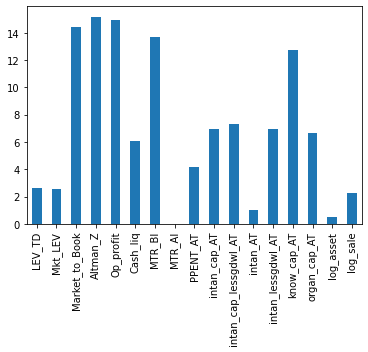

In [183]:
# % of OUTLIERS for each variables
fyp.vis_outliers(reg_df[des_BVs])
plt.show()
# % of OUTLIERS for each variables
fyp.vis_outliers(reg_df[des_ratios])
plt.show()

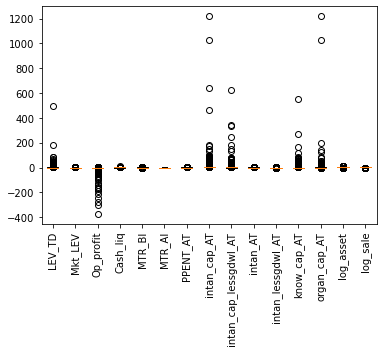

In [184]:
df = reg_df[des_ratios].drop(columns=['Market_to_Book', 'Altman_Z']) # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

In [185]:
importlib.reload(fyp)
reg_df_w = fyp.get_winsor_df(reg_df)
reg_df_bal_w = fyp.get_winsor_df(reg_df_bal)
robust_raw_w = fyp.get_winsor_df(robust_raw)

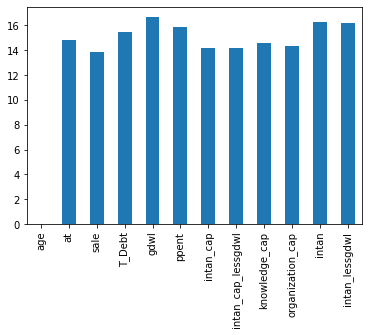

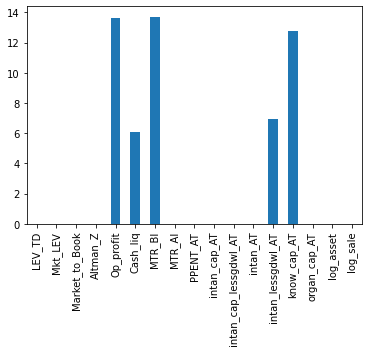

In [186]:
# % of OUTLIERS for each variables
df = reg_df_w
fyp.vis_outliers(df[des_BVs])
plt.show()
# % of OUTLIERS for each variables
fyp.vis_outliers(df[des_ratios])
plt.show()

In [187]:
sum_table_BV = reg_df_w[des_BVs].describe().T.round(1).iloc[:,1:]
sum_table_BV.to_excel('sum_table_BV.xlsx')
sum_table_BV

mean     std   min    25%    50%     75%      max
age                   30.0    19.1   1.0   14.0   25.0    47.0     76.0
at                  4692.6  9280.2  13.4  124.0  694.2  3579.9  36422.0
sale                3044.9  5589.5   0.4   76.6  542.3  2785.8  21566.9
T_Debt              1398.1  2870.1   0.0    2.6  101.0  1037.0  11137.0
gdwl                 601.1  1326.5   0.0    0.0   21.0   359.0   5218.0
ppent               1393.2  3115.0   0.3   10.9  109.8   822.1  12539.0
intan_cap           1255.6  1907.8  15.0   59.4  285.9  1471.1   5923.5
intan_cap_lessgdwl   627.1   939.8   5.1   30.5  158.3   733.3   2929.9
knowledge_cap        105.2   173.8   0.0    0.0    8.1   124.7    531.0
organization_cap     356.4   540.3   0.0   13.2   84.8   410.7   1675.4
intan                928.6  2010.3   0.0    0.7   50.2   588.9   7915.0
intan_lessgdwl       271.3   617.9   0.0    0.0   12.5   154.9   2474.7

In [188]:
sum_table_ratios = reg_df_w[des_ratios].describe().T.round(3).iloc[:,1:]
sum_table_ratios.to_excel('sum_table_ratios.xlsx')
sum_table_ratios

mean    std    min    25%    50%    75%     max
LEV_TD                 0.230  0.207  0.000  0.027  0.200  0.366   0.690
Mkt_LEV                0.143  0.144  0.000  0.011  0.104  0.231   0.475
Market_to_Book         2.963  2.416  0.352  1.169  2.151  4.030   8.185
Altman_Z               3.611  3.274 -1.327  1.415  3.090  5.339  10.045
Op_profit              0.035  0.173 -0.360 -0.000  0.093  0.148   0.211
Cash_liq               0.420  0.421  0.012  0.094  0.266  0.612   1.478
MTR_BI                 0.225  0.097  0.000  0.210  0.224  0.279   0.395
MTR_AI                 0.133  0.109  0.000  0.026  0.134  0.210   0.392
PPENT_AT               0.242  0.234  0.010  0.061  0.150  0.359   0.784
intan_cap_AT           0.635  0.423  0.066  0.275  0.596  0.898   1.432
intan_cap_lessgdwl_AT  0.393  0.326  0.017  0.113  0.323  0.583   1.046
intan_AT               0.185  0.203  0.000  0.006  0.105  0.320   0.636
intan_lessgdwl_AT      0.065  0.085  0.000  0.000  0.025  0.101   0.290
know_cap_AT            0.179  0.268  0.000  0.000  0.029  0.247   0.804
organ_cap_AT           0.220  0.197  0.000  0.057  0.163  0.340   0.611
log_asset              6.523  2.229  2.594  4.820  6.543  8.183  10.503
log_sale               6.014  2.525  0.627  4.360  6.298  7.933   9.979

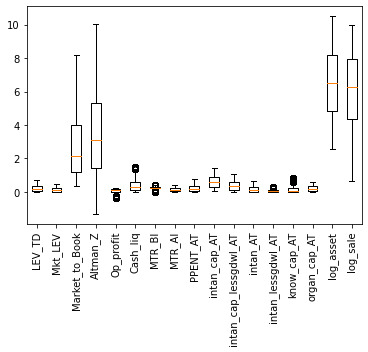

In [189]:
df = reg_df_w[des_ratios] # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f89e8a2dc40>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8a1ad6a850>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f89e8a2db80>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f89e8a2d5b0>}

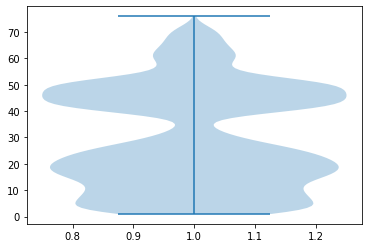

In [190]:
df = reg_df_w['age'] # des_BVs des_ratios
plt.violinplot(df) # violinplot boxplot
#plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

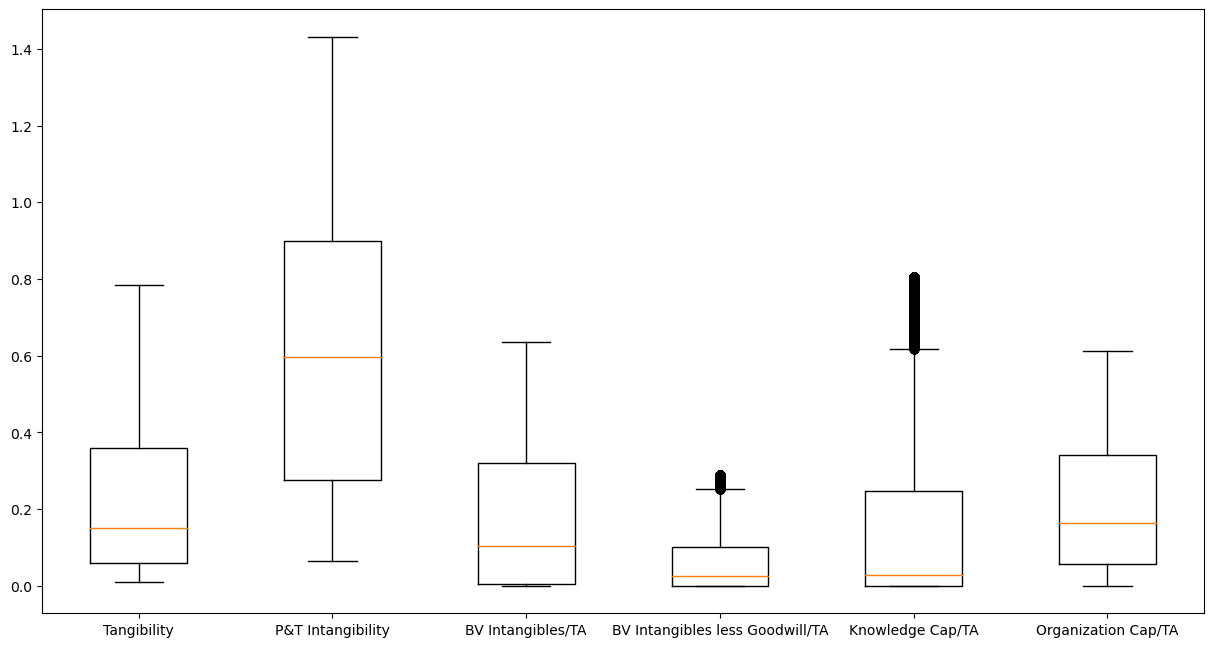

In [203]:
df = reg_df_w[['PPENT_AT', 'intan_cap_AT',
              'intan_AT', 'intan_lessgdwl_AT', 
              'know_cap_AT', 'organ_cap_AT']].set_axis(['Tangibility', 'P&T Intangibility', 
              'BV Intangibles/TA', 'BV Intangibles less Goodwill/TA', 
              'Knowledge Cap/TA', 'Organization Cap/TA'],axis=1) # des_BVs des_ratios 'intan_cap_lessgdwl_AT',  'Intangible less Goodwill/TA',
plt.figure(figsize=(15,8), dpi=100)
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=0);
plt.savefig('estimates_boxplot.png')

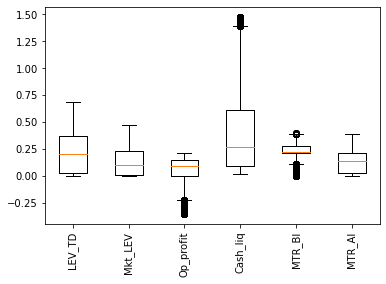

In [192]:
df = reg_df_w[['LEV_TD', 'Mkt_LEV', 'Op_profit', 'Cash_liq','MTR_BI', 'MTR_AI']] # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

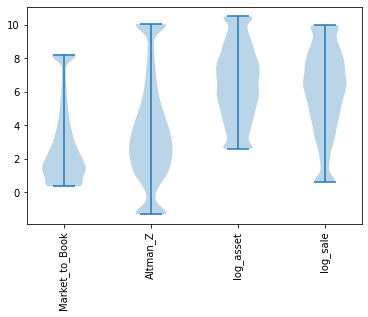

In [166]:
df = reg_df_w[['Market_to_Book', 'Altman_Z','log_asset', 'log_sale']] # des_BVs des_ratios
plt.violinplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

In [204]:
all_cols = ['LEV_TD','Mkt_LEV','age',
           'intan_cap_AT', 'intan_AT', 'intan_lessgdwl_AT', 
           'know_cap_AT', 'organ_cap_AT', 'PPENT_AT',
           'log_asset','Market_to_Book', 'Op_profit', 'Cash_liq', 'MTR_AI'] # 'intan_cap_lessgdwl_AT',  'Altman_Z',
rename_cols = ['LEV','Mkt LEV','Firm Age',
               'P&T Intangibility', 'BV Intangibles/TA', 'BV Intangibles less Goodwill/TA', 
               'Knowledge Cap/TA', 'Organization Cap/TA', 'Tangibility',
               'log Total Assets','Market to Book', 'Operating Profitability', 'Cash Liquidity', 'Marginal Tax Rate'] # 'Altman Z Score',

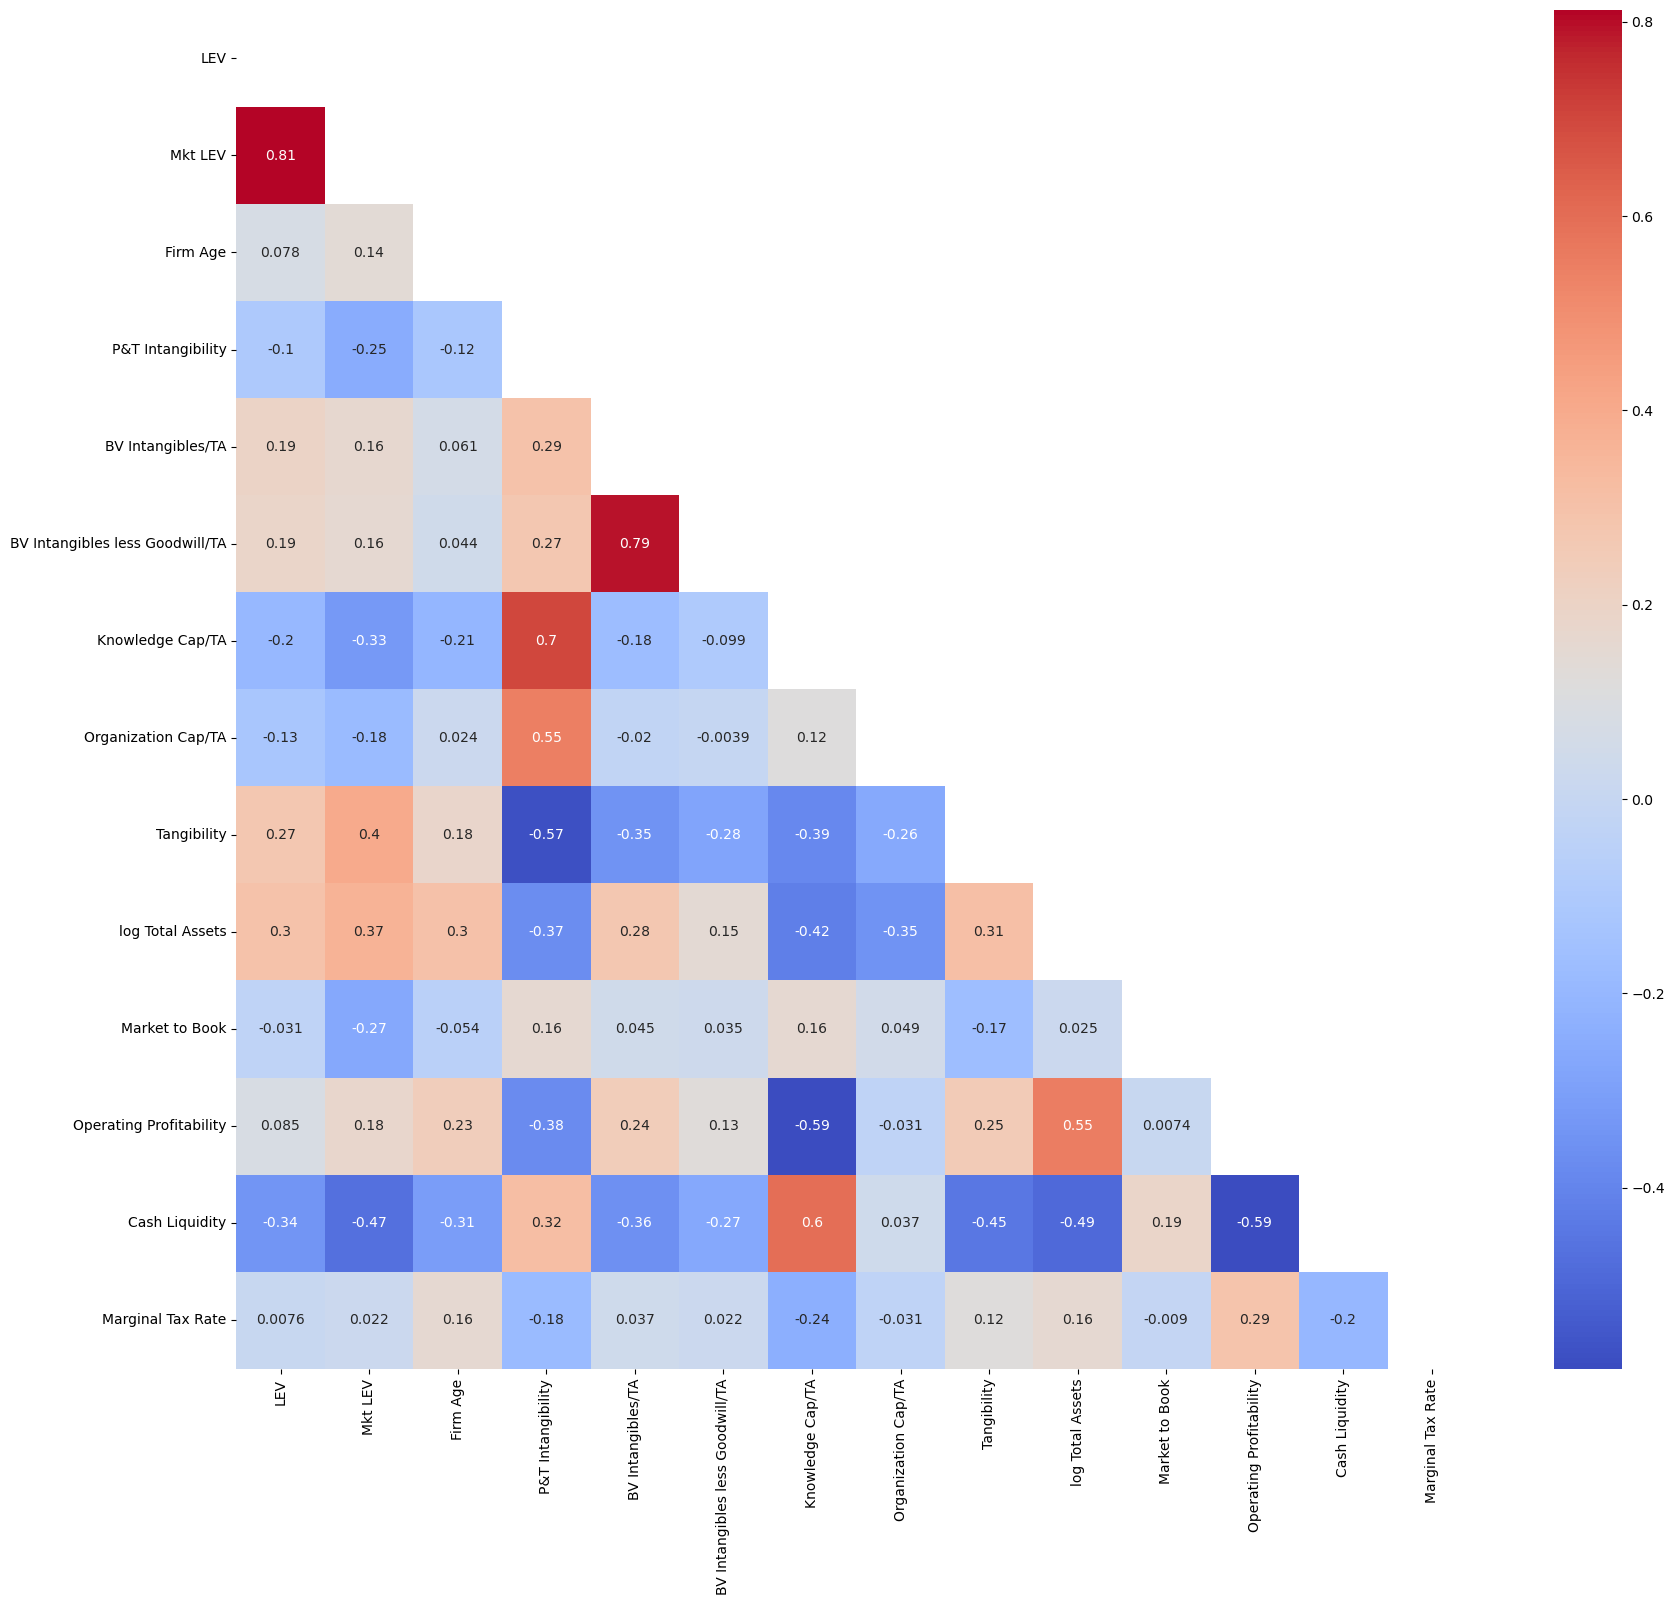

In [207]:
import seaborn as sns

# Multicollinearity check
corr_matrix = reg_df_w[all_cols].set_axis(rename_cols, axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20,18), dpi=100)
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True);
plt.savefig('corr_matrix.png')

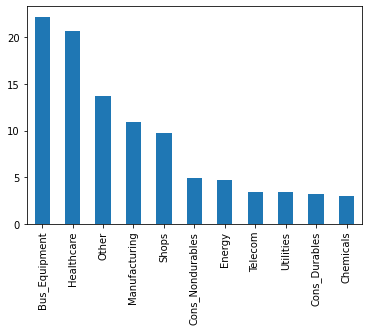

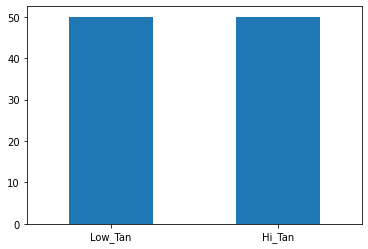

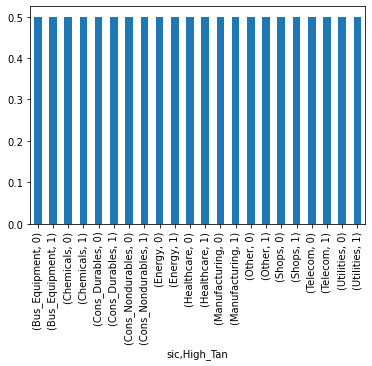

In [169]:
importlib.reload(fyp)
# subsamples of industry size, equal split between Hitan and lowtan overall and within industry
reg_df_w = fyp.Tangibility_dummy(reg_df_w)

In [170]:
import xlwings as xw
industry_firms = reg_df_w.groupby('sic')['gvkey'].nunique()
industry_firms.index = ['Business Equipment', 'Chemicals', 'Consumer Durables', 'Consumer Nondurables',
                        'Energy', 'Healthcare', 'Manufacturing', 'Other', 'Shops', 'Telecom',
                        'Utilities']
industry_pct = round(reg_df_w.groupby('sic')['gvkey'].nunique() / reg_df_w['gvkey'].nunique() * 100, 2)
industry_pct = pd.Series(industry_pct.values, name = 'Percentage', index=None)
industry_firms = pd.DataFrame(pd.merge(industry_firms, industry_pct, on = industry_firms.index))
#print(industry_firms)

industry_N = reg_df_w['sic'].value_counts()
industry_N.index = ['Business Equipment', 'Chemicals', 'Consumer Durables', 'Consumer Nondurables',
                    'Energy', 'Healthcare', 'Manufacturing', 'Other', 'Shops', 'Telecom',
                    'Utilities']
industry_N_pct = round(reg_df_w['sic'].value_counts() / len(reg_df_w['sic']) * 100, 2)
industry_N = pd.DataFrame(pd.merge(industry_N, industry_N_pct, on=industry_N.index))
#print(industry_N)

industry_firms = pd.merge(industry_firms, industry_N, on = 'key_0').set_axis(['Industry','Firms','Firms(%)',
                                                                              'Observations','Observations(%)'], axis=1)
industry_firms.index = industry_firms['Industry']
industry_firms = industry_firms.drop(columns = ['Industry'])
print(industry_firms)
industry_firms.to_excel('industry_firms.xlsx')

wb = xw.Book('industry_firms.xlsx')
#wb.sheets[0].range('C1:C12').value = industry_pct
#wb.sheets[0].range('A:A').api.delete()

wb.sheets[0].range('A13').value = 'Total'
wb.sheets[0].range('B13').value = reg_df_w['gvkey'].nunique()
wb.sheets[0].range('C13').value = 100
wb.sheets[0].range('D13').value = len(reg_df_w['sic'])
wb.sheets[0].range('E13').value = 100
#sum(wb.sheets[0].range('B2:B12').value)

                      Firms  Firms(%)  Observations  Observations(%)
Industry                                                            
Business Equipment      895     23.71          7971            22.19
Chemicals               107      2.84          7436            20.70
Consumer Durables       109      2.89          4925            13.71
Consumer Nondurables    178      4.72          3919            10.91
Energy                  173      4.58          3495             9.73
Healthcare              857     22.71          1775             4.94
Manufacturing           380     10.07          1673             4.66
Other                   485     12.85          1236             3.44
Shops                   345      9.14          1235             3.44
Telecom                 127      3.37          1170             3.26
Utilities               118      3.13          1080             3.01


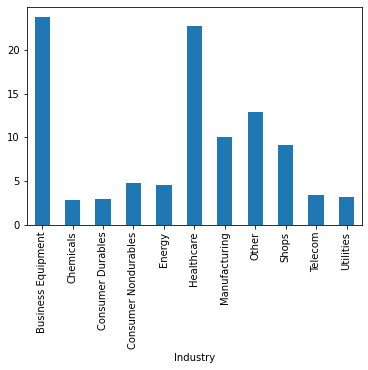

In [171]:
industry_firms['Firms(%)'].plot(kind='bar');

<AxesSubplot:xlabel='Industry'>

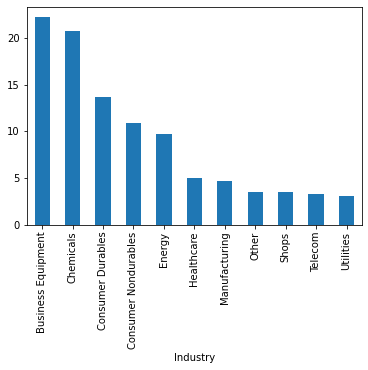

In [172]:
industry_firms['Observations(%)'].plot(kind='bar')

In [173]:
# Groupby industry descriptive statistics for leverage vars
reg_df_w.groupby('sic')[['LEV_TD','Mkt_LEV']].describe().round(3).iloc[:,[0,1,2,5,9,10,13]]

LEV_TD                      Mkt_LEV              
                   count   mean    std    50%    mean    std    50%
sic                                                                
Bus_Equipment     7971.0  0.161  0.180  0.106   0.086  0.109  0.045
Chemicals         1080.0  0.297  0.175  0.291   0.177  0.124  0.158
Cons_Durables     1170.0  0.230  0.192  0.195   0.155  0.142  0.123
Cons_Nondurables  1775.0  0.259  0.190  0.264   0.162  0.133  0.147
Energy            1673.0  0.283  0.174  0.262   0.223  0.147  0.200
Healthcare        7436.0  0.195  0.228  0.102   0.085  0.119  0.031
Manufacturing     3919.0  0.230  0.181  0.221   0.156  0.133  0.135
Other             4925.0  0.253  0.208  0.222   0.174  0.155  0.140
Shops             3495.0  0.269  0.216  0.237   0.179  0.154  0.146
Telecom           1236.0  0.383  0.220  0.397   0.272  0.160  0.274
Utilities         1235.0  0.362  0.114  0.357   0.289  0.096  0.292

In [174]:
importlib.reload(fyp)
reg_df_w = fyp.LEV_dummy(reg_df_w)

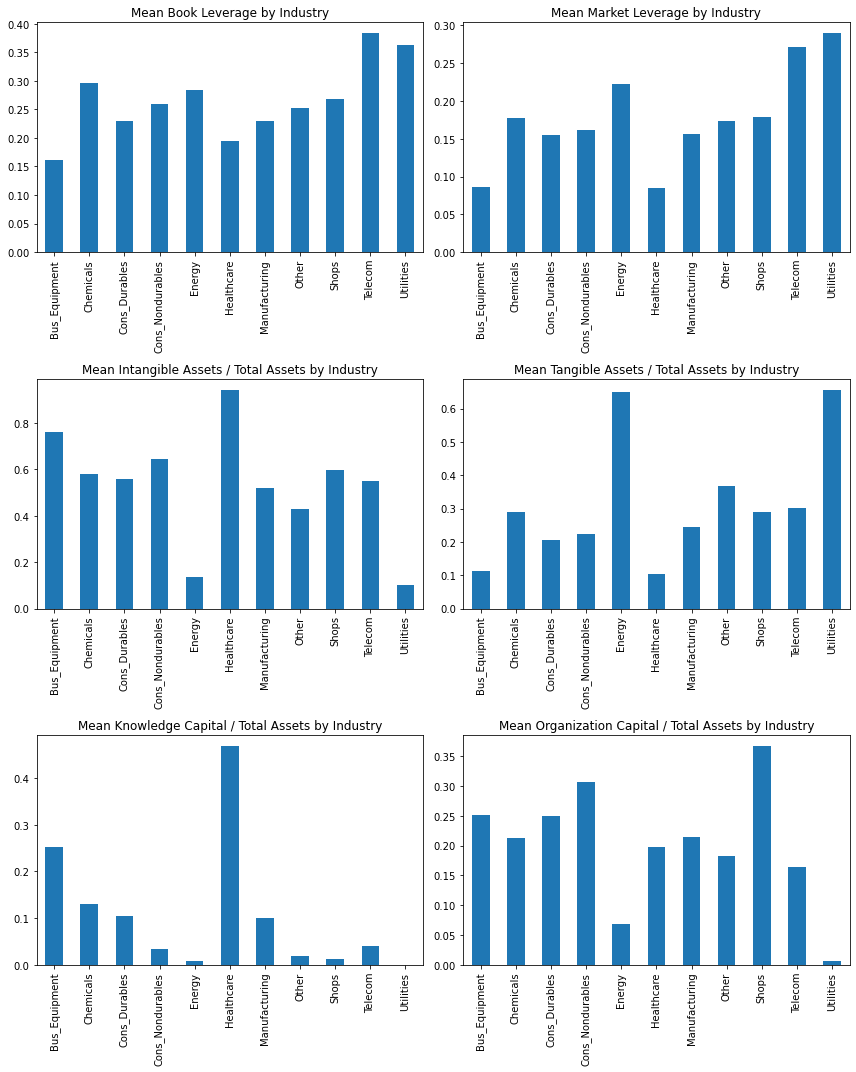

In [144]:
importlib.reload(fyp)
fyp.Industry_regvar_vis(reg_df_w, w = 12,h = 15)

In [145]:
reg_df_w.groupby('sic')[['PPENT_AT','intan_cap_AT','know_cap_AT', 'organ_cap_AT']].describe() \
.round(3).iloc[:,[0,1,2,5,9,10,13,17,18,21,25,26,29]] #[1,2,5,9,10,13]

PPENT_AT                      intan_cap_AT                \
                    count   mean    std    50%         mean    std    50%   
sic                                                                         
Bus_Equipment      7971.0  0.112  0.111  0.079        0.763  0.373  0.751   
Chemicals          1080.0  0.291  0.177  0.254        0.581  0.364  0.549   
Cons_Durables      1170.0  0.205  0.117  0.196        0.558  0.330  0.510   
Cons_Nondurables   1775.0  0.225  0.160  0.194        0.643  0.316  0.645   
Energy             1673.0  0.649  0.181  0.746        0.138  0.151  0.066   
Healthcare         7436.0  0.105  0.122  0.065        0.944  0.442  0.948   
Manufacturing      3919.0  0.245  0.161  0.205        0.521  0.307  0.490   
Other              4925.0  0.367  0.286  0.320        0.428  0.362  0.341   
Shops              3495.0  0.291  0.209  0.245        0.598  0.312  0.574   
Telecom            1236.0  0.301  0.211  0.282        0.551  0.304  0.521   
Utilities          1235.0  0.657  0.174  0.709        0.103  0.093  0.066   

                 know_cap_AT               organ_cap_AT                
                        mean    std    50%         mean    std    50%  
sic                                                                    
Bus_Equipment          0.251  0.240  0.177        0.251  0.179  0.202  
Chemicals              0.130  0.194  0.066        0.212  0.168  0.164  
Cons_Durables          0.104  0.158  0.048        0.249  0.180  0.210  
Cons_Nondurables       0.034  0.095  0.000        0.306  0.193  0.283  
Energy                 0.008  0.034  0.000        0.069  0.096  0.039  
Healthcare             0.468  0.322  0.504        0.198  0.210  0.124  
Manufacturing          0.101  0.168  0.042        0.214  0.156  0.173  
Other                  0.020  0.086  0.000        0.183  0.192  0.109  
Shops                  0.012  0.080  0.000        0.367  0.203  0.382  
Telecom                0.041  0.138  0.000        0.164  0.147  0.130  
Utilities              0.000  0.003  0.000        0.007  0.038  0.000

In [146]:
# outliers = find_outliers_IQR(reg_df[des_BVs])
# print('number of outliers: ' + str(len(outliers)))
# print('max outlier value: ' + str(outliers.max()))
# print('min outlier value: ' + str(outliers.min()))

# # Visualizations of Groupby industry descriptive statistics for leverage vars
# reg_df_w.groupby('sic')['Med_LEV'].unique().astype('float').plot(kind='bar');
# plt.show()
# reg_df_w.groupby('sic')['Med_Mkt_LEV'].unique().astype('float').plot(kind='bar');
# plt.show()

In [ ]:
panel = df.copy()
panel = panel.set_index(['gvkey','fyear'])
years = panel.index.get_level_values('fyear').to_list()
panel['fyear'] = pd.Categorical(years)

IV = ['intan_cap_AT','PPENT_AT']
control = ['sale','MV_CE','Op_profitability','Market_to_Book','cash_liquidity']
indust = ['Consumer','Manufacturing','Healthcare','Other']

#control.append('Med_LEV')
# OR
IV.extend(control)
IV.extend(indust)

In [589]:
# # Import and preprocess data
# dataset = pd.read_csv(‘Guns.csv’, usecols = [‘state’, ‘year’, ‘income’, ‘violent’],\
#  index_col = [‘state’, ‘year’])
# years = dataset.index.get_level_values(‘year’).to_list()
# dataset[‘year’] = pd.Categorical(years)
panel = df.copy()
panel = panel.set_index(['gvkey','fyear'])
years = panel.index.get_level_values('fyear').to_list()
panel['fyear'] = pd.Categorical(years)

In [ ]:
IV = ['intan_cap_AT','PPENT_AT']
control = ['sale','MV_CE','Op_profitability','Market_to_Book','cash_liquidity']
indust = ['Consumer','Manufacturing','Healthcare','Other']

#control.append('Med_LEV')
# OR
IV.extend(control)
IV.extend(indust)

In [ ]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

exog = sm.tools.tools.add_constant(panel[IV])
endog = panel['LEV']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [ ]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection

fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [ ]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

pooled_OLS_dataset = pd.concat([panel, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['fyear'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(panel['LEV']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

In [ ]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

# output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 
# 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), 
# and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation)

In [ ]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

exog = sm.tools.tools.add_constant(panel[IV])
endog = panel['LEV']

# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 

# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True,drop_absorbed=True) 
fe_res = model_fe.fit() 

#print results
print(re_res)
print(fe_res)

In [ ]:
import numpy.linalg as la
from scipy import stats
import numpy as np

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))